<a href="https://colab.research.google.com/github/montimaj/Deep-Learning-SE-6213/blob/master/HW9/HW9_Sayantan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **HW9**
### *Create a Generative Adversarial Network for the Celebrity data faces*
### *Use notebook example given for the MNIST dataset*

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import matplotlib.pyplot as plt
import os, time  
import numpy as np 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#  you may also import any other packages you deem necessary
#from tensorflow.keras.layers import Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tensorflow.keras.utils import Progbar

In [2]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2020-11-16 02:34:36--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.145
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  42.3MB/s    in 33s     

2020-11-16 02:35:10 (41.5 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



### You may need to extract zip file

In [3]:
import zipfile
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

Number of images in the folder

In [4]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [18]:
dir_data      = "data_faces/img_align_celeba/"
Ntrain        = 20000   ## reduced the number of training images to 10%
Ntest         = 1000
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (32, 32, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (20000, 32, 32, 3)
X_test.shape = (1000, 32, 32, 3)


### Display some of the images

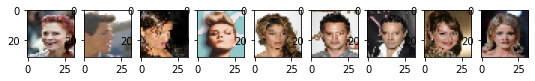

In [19]:
fig = plt.figure(figsize=(10,4))
nplot = 10
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()

###**Generator**: the generator generates new data instances that are "similar" to the training data, in our case celebA images. Generator takes random latent vector and output a "fake" image of the same size as our reshaped celebA image.

## 25 points

In [20]:
import numpy as np
from keras import layers, models
from keras.optimizers import Adam

optimizer = Adam(0.00007, 0.5)

def build_generator(img_shape, noise_shape):
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(128 * 8 * 8, activation="relu")(d)
    d = layers.Reshape((8, 8, 128))(d)
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D(64  , (1, 1) , activation='relu' , padding='same', name="block_4")(d) ## 16,16


    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D(64  , (1, 1) , activation='relu' , padding='same', name="block_5")(d) ## 32,32
    
    if img_shape[0] == 64:
        d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
        d = layers.Conv2D(64  , (1 , 1) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
    
    img = layers.Conv2D(3 , (1 , 1) , activation='sigmoid' , padding='same', name="final_block")(d) ## 32, 32
    model = models.Model(input_noise, img)
    model.summary() 
    return model 

In [21]:
## Set the dimension of latent variables to be 100
noise_shape = (100,)
generator = build_generator(img_shape, noise_shape = noise_shape)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_7 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       65536     
_________________________________________________________________
block_4 (Conv2D)             (None, 16, 16, 64)        8256      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 32)       

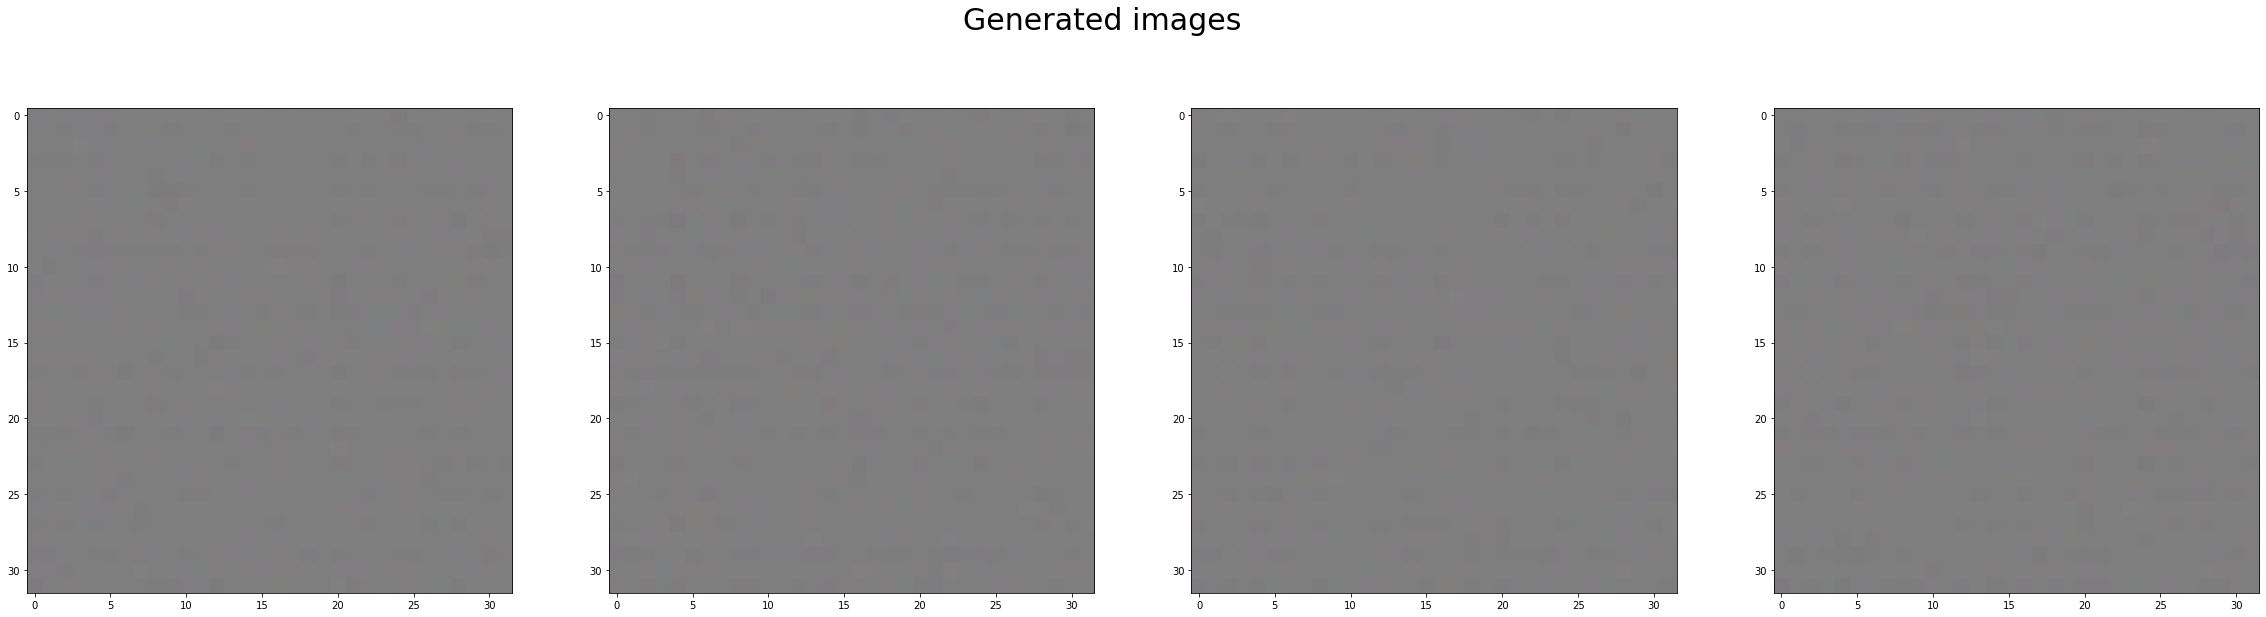

In [22]:
def get_noise(nsample=1, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample, nlatent_dim))
    return(noise)

def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 4
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

###**Discriminator**: the discriminator evaluate the authenticity of provided images; it classifies the images from the generator and the original image. Discriminator takes true of fake images and output the probability estimate ranging between 0 and 1.

## 25 points

In [23]:
def build_discriminator(img_shape, n_output=1):
    input_img = layers.Input(shape=img_shape)    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)

    
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu")(x)
    out = layers.Dense(n_output, activation='sigmoid')(x)
    model = models.Model(input_img, out)
    
    return model

In [24]:
discriminator  = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, 
                      metrics=['accuracy'])
discriminator.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)         

In [25]:
z = layers.Input(shape=noise_shape)
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_7 (Functional)    (None, 32, 32, 3)         8584515   
_________________________________________________________________
functional_9 (Functional)    (None, 1)                 6711585   
Total params: 15,296,100
Trainable params: 8,584,515
Non-trainable params: 6,711,585
_________________________________________________________________


### Preprocessing for training
## 20 points


In [26]:
def train(models, X_train, noise_plot, dir_result="/result/", epochs=10000, batch_size=128):
  combined, discriminator, generator = models
  nlatent_dim = noise_plot.shape[1]
  half_batch  = int(batch_size / 2)
  history = []
  for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], half_batch)
      imgs = X_train[idx]
      noise = get_noise(half_batch, nlatent_dim)

      gen_imgs = generator.predict(noise)

      d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
      d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = get_noise(batch_size, nlatent_dim)

      valid_y = (np.array([1] * batch_size)).reshape(batch_size, 1)
    
      g_loss = combined.train_on_batch(noise, valid_y)

      history.append({"D": d_loss[0], "G": g_loss})
      
      if epoch % 100 == 0:
          print ("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(
              epoch, d_loss[0], 100 * d_loss[1], g_loss))
      if epoch % int(epochs / 100) == 0:
          plot_generated_images(noise_plot,
                                path_save=dir_result+"/image_{:05.0f}.png".format(epoch),
                                titleadd="Epoch {}".format(epoch))
      if epoch % 1000 == 0:
          plot_generated_images(noise_plot,
                                titleadd="Epoch {}".format(epoch))
                  
  return history


### Training the model

## 20 points

Epoch 00000 [D loss: 0.724, acc.: 049.4%] [G loss: 0.649]


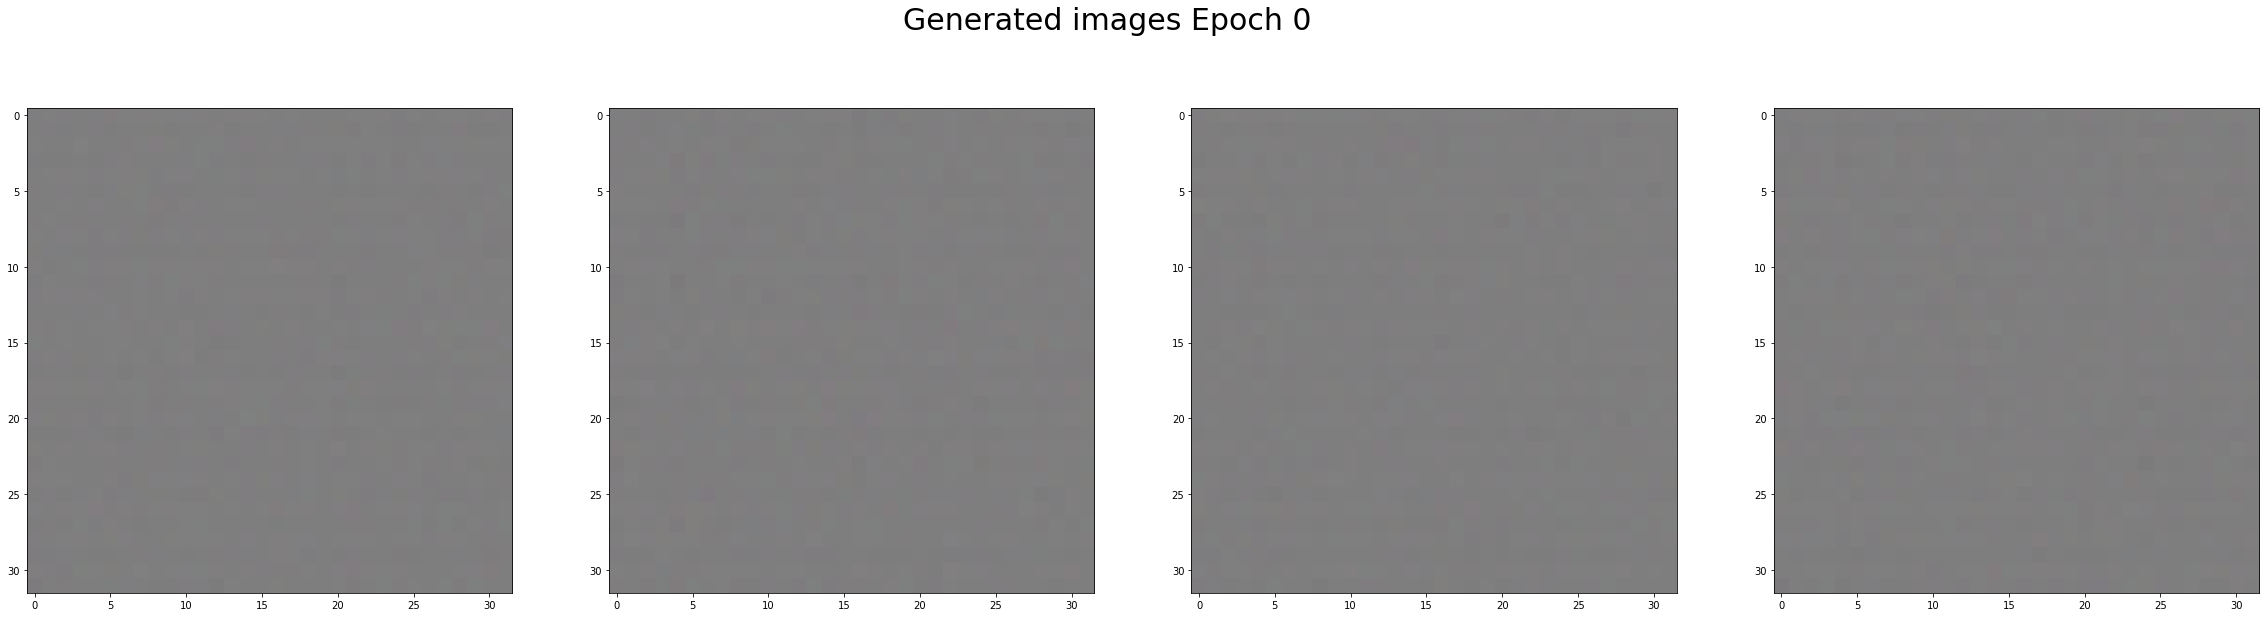

Epoch 00100 [D loss: 0.028, acc.: 100.0%] [G loss: 3.082]
Epoch 00200 [D loss: 17.613, acc.: 050.0%] [G loss: 4.516]
Epoch 00300 [D loss: 0.244, acc.: 092.4%] [G loss: 2.289]
Epoch 00400 [D loss: 0.354, acc.: 086.7%] [G loss: 1.910]
Epoch 00500 [D loss: 0.336, acc.: 086.3%] [G loss: 2.462]
Epoch 00600 [D loss: 0.243, acc.: 093.8%] [G loss: 3.234]
Epoch 00700 [D loss: 0.293, acc.: 090.8%] [G loss: 3.598]
Epoch 00800 [D loss: 0.192, acc.: 095.5%] [G loss: 2.978]
Epoch 00900 [D loss: 0.153, acc.: 094.9%] [G loss: 3.067]
Epoch 01000 [D loss: 0.274, acc.: 090.8%] [G loss: 2.314]


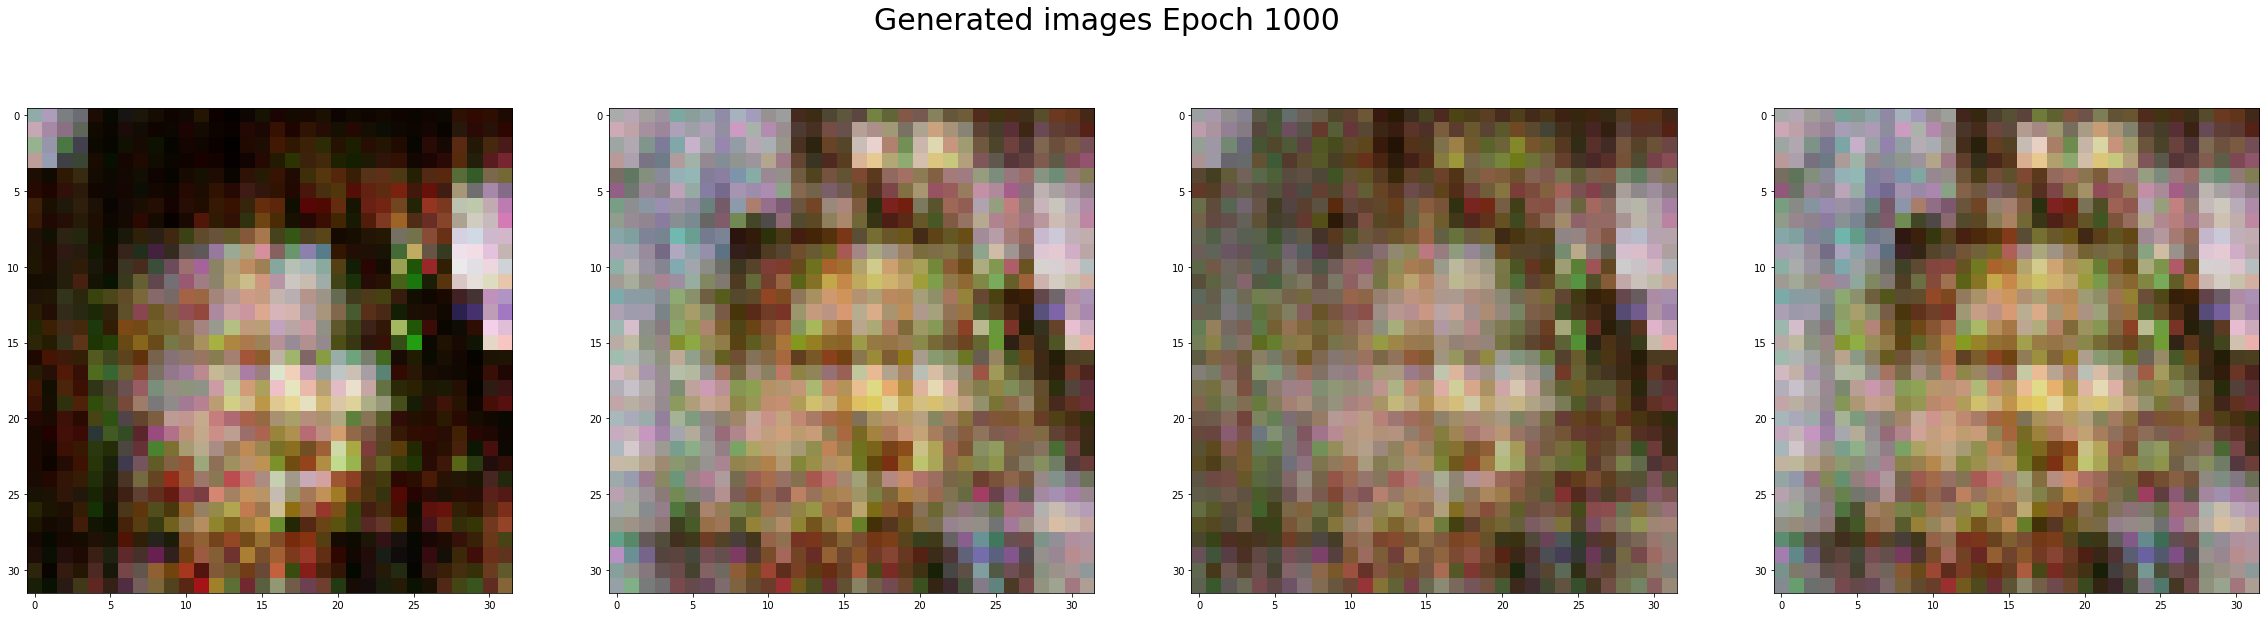

Epoch 01100 [D loss: 0.398, acc.: 082.8%] [G loss: 3.372]
Epoch 01200 [D loss: 0.136, acc.: 097.2%] [G loss: 3.273]
Epoch 01300 [D loss: 0.146, acc.: 095.2%] [G loss: 2.913]
Epoch 01400 [D loss: 0.104, acc.: 097.2%] [G loss: 3.077]
Epoch 01500 [D loss: 0.190, acc.: 094.9%] [G loss: 3.803]
Epoch 01600 [D loss: 0.164, acc.: 095.4%] [G loss: 2.577]
Epoch 01700 [D loss: 0.421, acc.: 084.8%] [G loss: 2.412]
Epoch 01800 [D loss: 0.197, acc.: 092.9%] [G loss: 3.923]
Epoch 01900 [D loss: 0.107, acc.: 097.0%] [G loss: 3.345]
Epoch 02000 [D loss: 0.214, acc.: 093.5%] [G loss: 2.939]


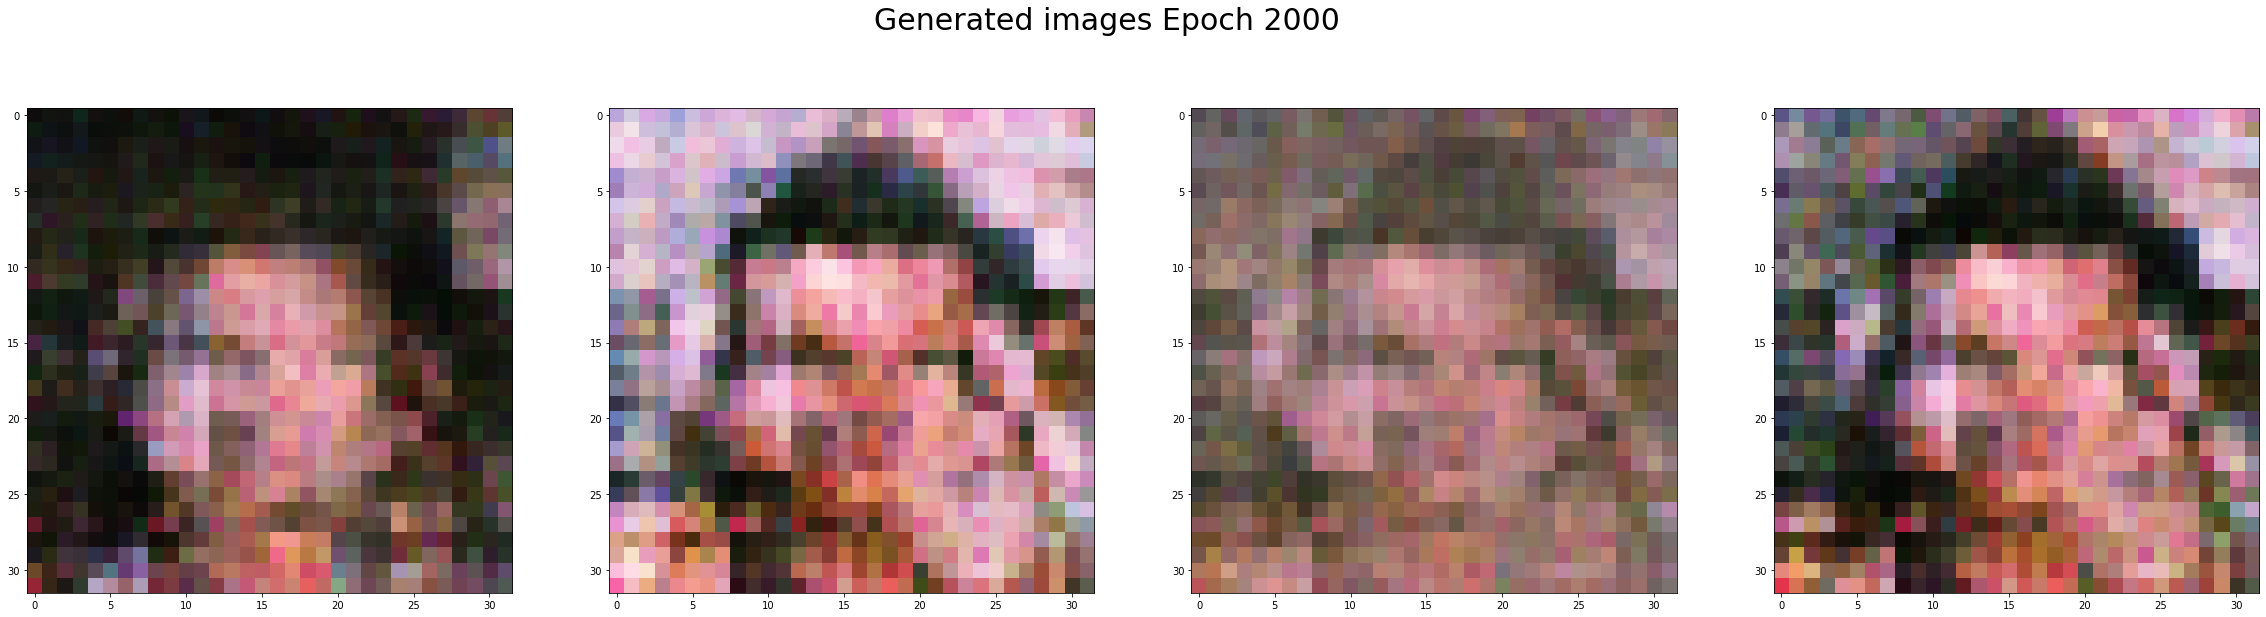

Epoch 02100 [D loss: 0.264, acc.: 089.6%] [G loss: 3.739]
Epoch 02200 [D loss: 0.299, acc.: 088.6%] [G loss: 3.112]
Epoch 02300 [D loss: 0.228, acc.: 092.6%] [G loss: 3.496]
Epoch 02400 [D loss: 0.300, acc.: 089.0%] [G loss: 4.212]
Epoch 02500 [D loss: 0.282, acc.: 091.2%] [G loss: 2.737]
Epoch 02600 [D loss: 0.197, acc.: 092.5%] [G loss: 3.399]
Epoch 02700 [D loss: 0.379, acc.: 084.2%] [G loss: 2.139]
Epoch 02800 [D loss: 0.371, acc.: 085.5%] [G loss: 2.515]
Epoch 02900 [D loss: 0.547, acc.: 074.5%] [G loss: 2.209]
Epoch 03000 [D loss: 0.408, acc.: 082.2%] [G loss: 2.527]


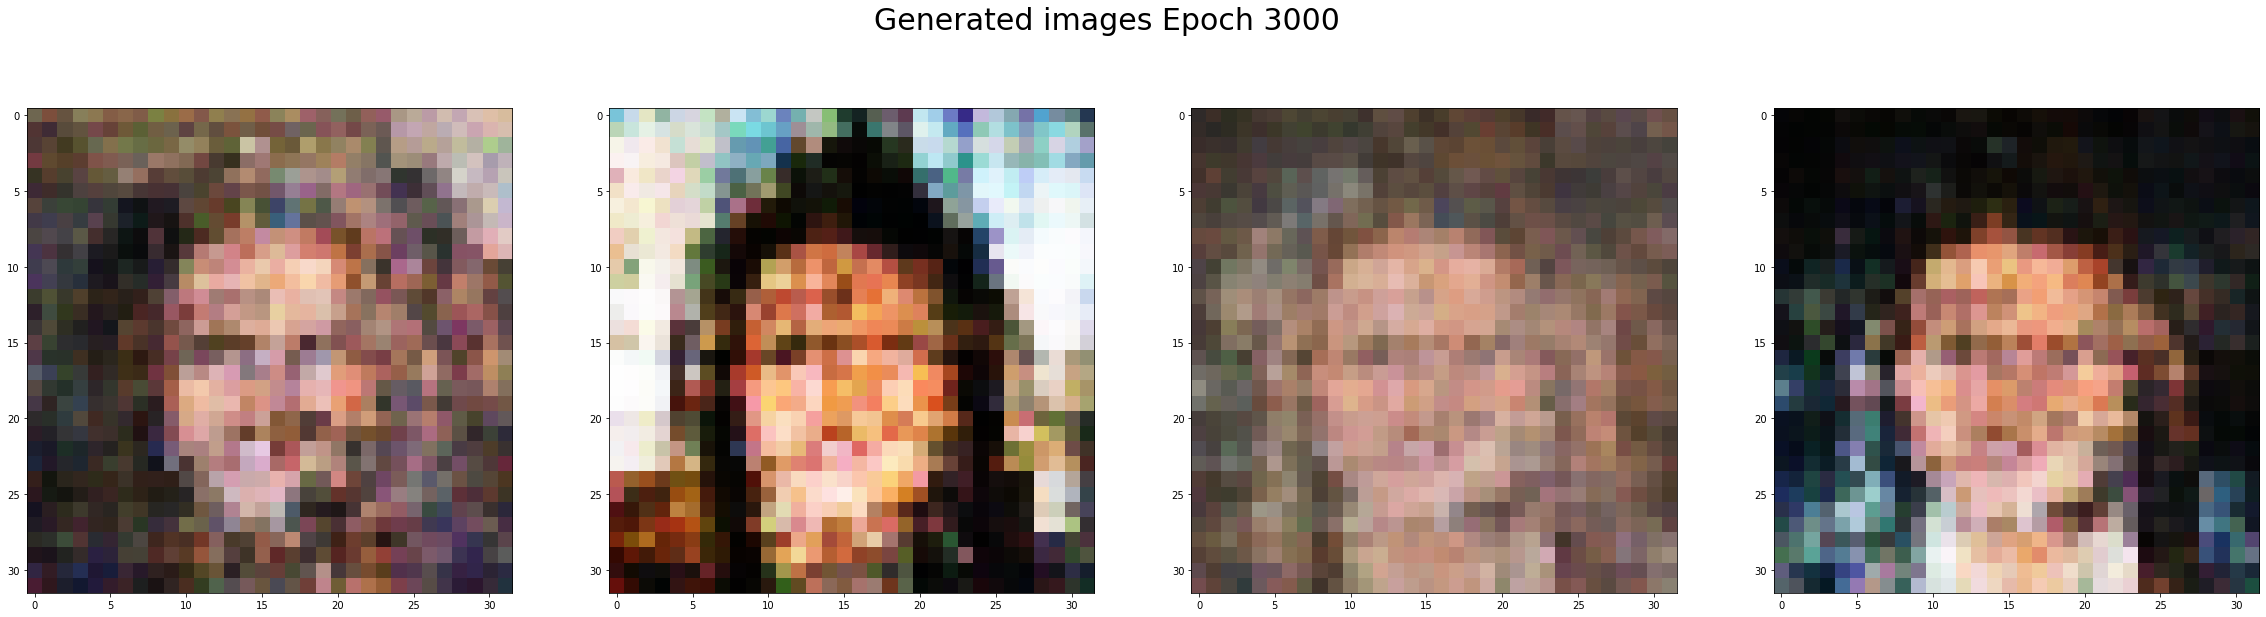

Epoch 03100 [D loss: 0.402, acc.: 082.7%] [G loss: 2.195]
Epoch 03200 [D loss: 0.368, acc.: 085.6%] [G loss: 2.170]
Epoch 03300 [D loss: 0.442, acc.: 079.2%] [G loss: 2.034]
Epoch 03400 [D loss: 0.532, acc.: 072.7%] [G loss: 1.730]
Epoch 03500 [D loss: 0.483, acc.: 079.1%] [G loss: 1.892]
Epoch 03600 [D loss: 0.455, acc.: 078.9%] [G loss: 1.826]
Epoch 03700 [D loss: 0.493, acc.: 077.0%] [G loss: 1.714]
Epoch 03800 [D loss: 0.465, acc.: 079.5%] [G loss: 1.750]
Epoch 03900 [D loss: 0.445, acc.: 081.1%] [G loss: 1.808]
Epoch 04000 [D loss: 0.485, acc.: 078.5%] [G loss: 1.606]


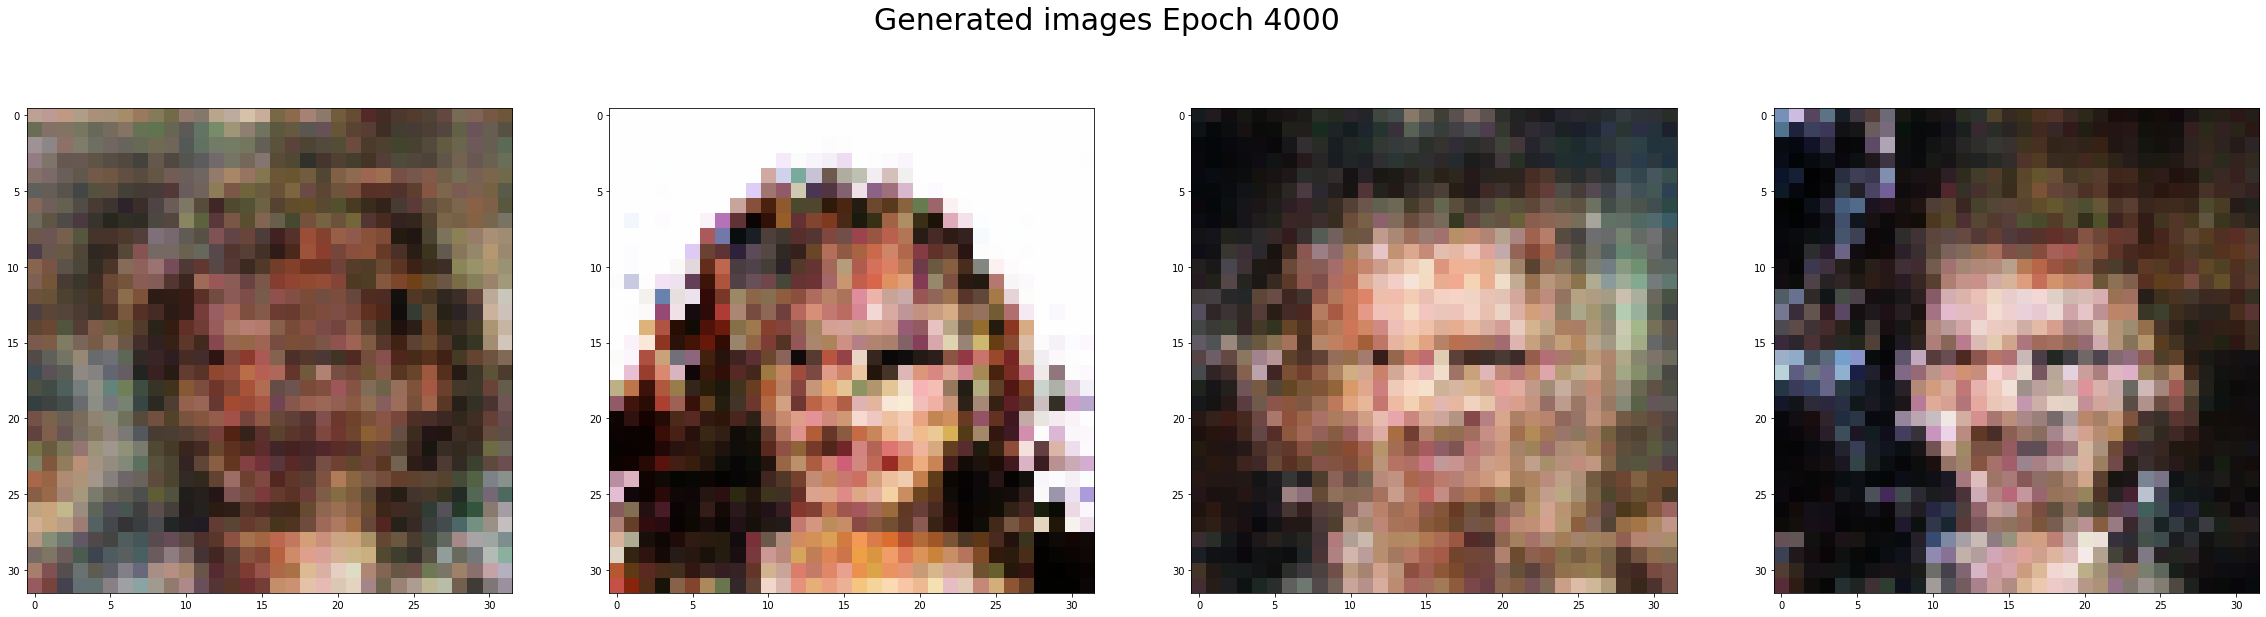

Epoch 04100 [D loss: 0.452, acc.: 080.1%] [G loss: 1.736]
Epoch 04200 [D loss: 0.475, acc.: 077.8%] [G loss: 1.622]
Epoch 04300 [D loss: 0.474, acc.: 077.4%] [G loss: 1.801]
Epoch 04400 [D loss: 0.487, acc.: 077.2%] [G loss: 1.682]
Epoch 04500 [D loss: 0.499, acc.: 074.9%] [G loss: 1.530]
Epoch 04600 [D loss: 0.492, acc.: 075.4%] [G loss: 1.509]
Epoch 04700 [D loss: 0.532, acc.: 074.5%] [G loss: 1.616]
Epoch 04800 [D loss: 0.479, acc.: 076.1%] [G loss: 1.675]
Epoch 04900 [D loss: 0.490, acc.: 075.5%] [G loss: 1.643]
Epoch 05000 [D loss: 0.492, acc.: 075.5%] [G loss: 1.538]


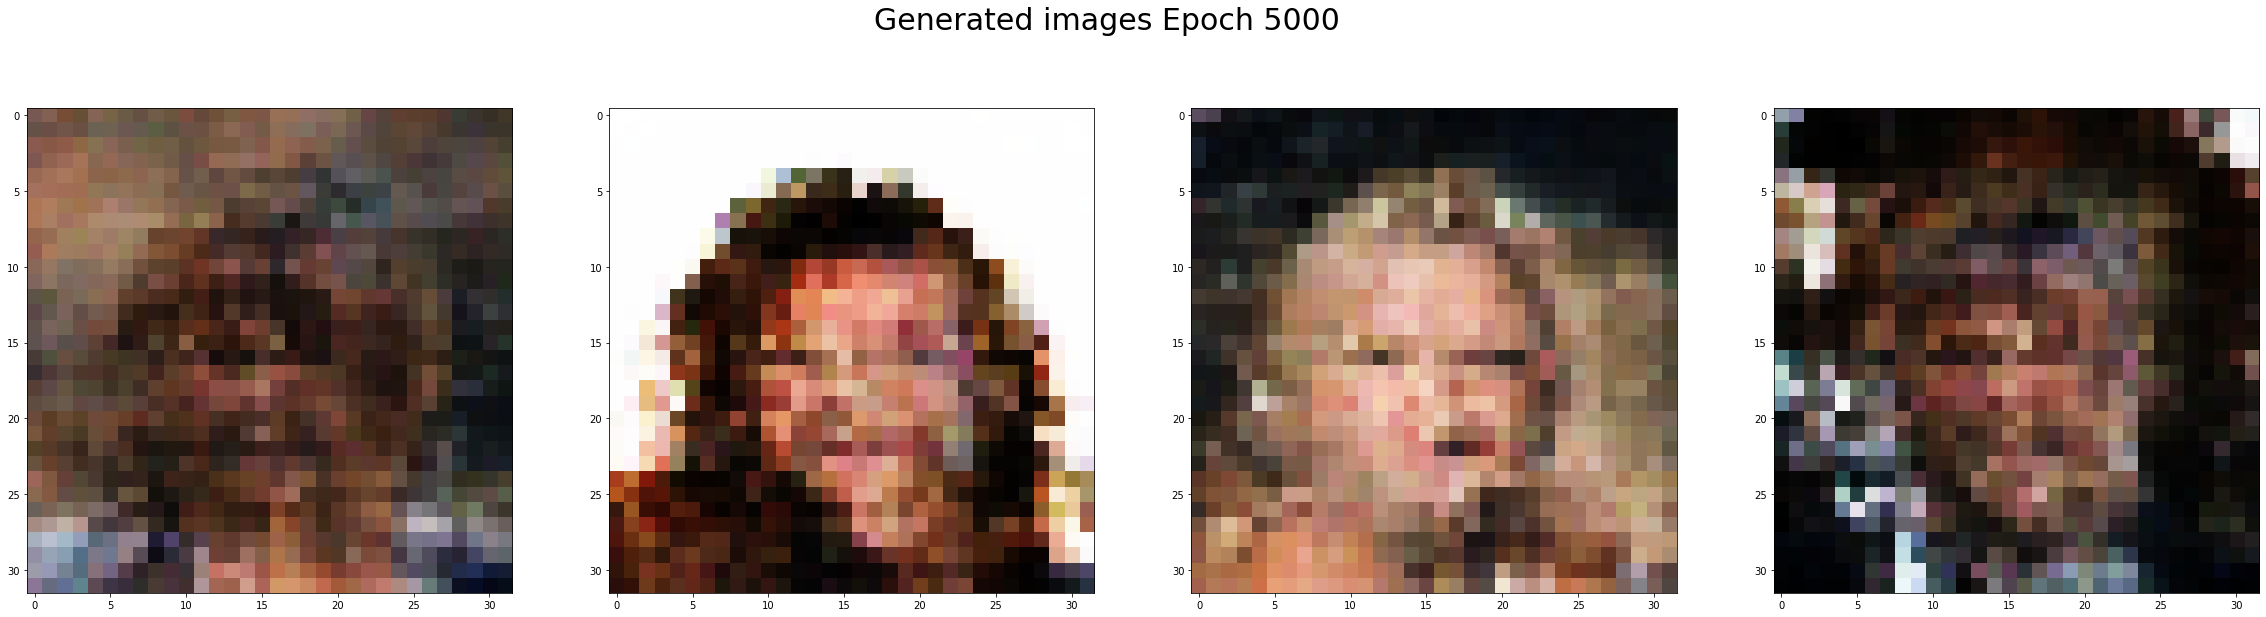

Epoch 05100 [D loss: 0.478, acc.: 077.0%] [G loss: 1.570]
Epoch 05200 [D loss: 0.522, acc.: 072.9%] [G loss: 1.461]
Epoch 05300 [D loss: 0.494, acc.: 074.0%] [G loss: 1.484]
Epoch 05400 [D loss: 0.520, acc.: 072.5%] [G loss: 1.487]
Epoch 05500 [D loss: 0.446, acc.: 079.4%] [G loss: 1.482]
Epoch 05600 [D loss: 0.477, acc.: 076.9%] [G loss: 1.492]
Epoch 05700 [D loss: 0.459, acc.: 077.2%] [G loss: 1.583]
Epoch 05800 [D loss: 0.479, acc.: 076.6%] [G loss: 1.503]
Epoch 05900 [D loss: 0.496, acc.: 075.7%] [G loss: 1.611]
Epoch 06000 [D loss: 0.472, acc.: 076.1%] [G loss: 1.446]


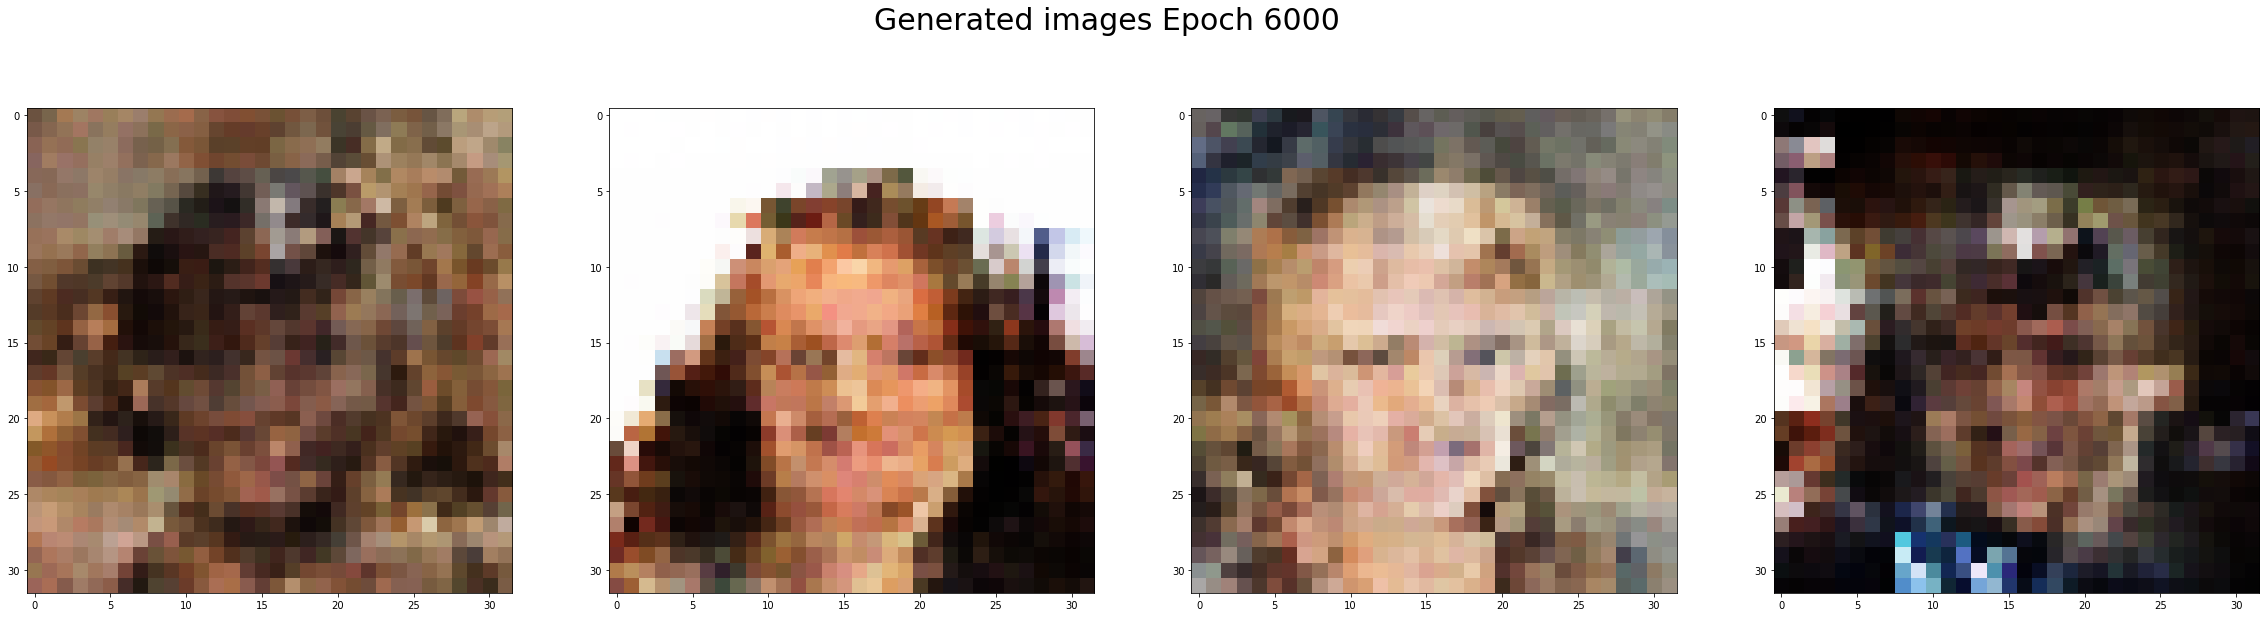

Epoch 06100 [D loss: 0.489, acc.: 075.0%] [G loss: 1.545]
Epoch 06200 [D loss: 0.507, acc.: 075.0%] [G loss: 1.539]
Epoch 06300 [D loss: 0.459, acc.: 078.9%] [G loss: 1.578]
Epoch 06400 [D loss: 0.470, acc.: 076.7%] [G loss: 1.547]
Epoch 06500 [D loss: 0.458, acc.: 077.9%] [G loss: 1.500]
Epoch 06600 [D loss: 0.438, acc.: 079.2%] [G loss: 1.551]
Epoch 06700 [D loss: 0.448, acc.: 078.1%] [G loss: 1.503]
Epoch 06800 [D loss: 0.467, acc.: 076.8%] [G loss: 1.549]
Epoch 06900 [D loss: 0.421, acc.: 081.1%] [G loss: 1.527]
Epoch 07000 [D loss: 0.439, acc.: 079.1%] [G loss: 1.513]


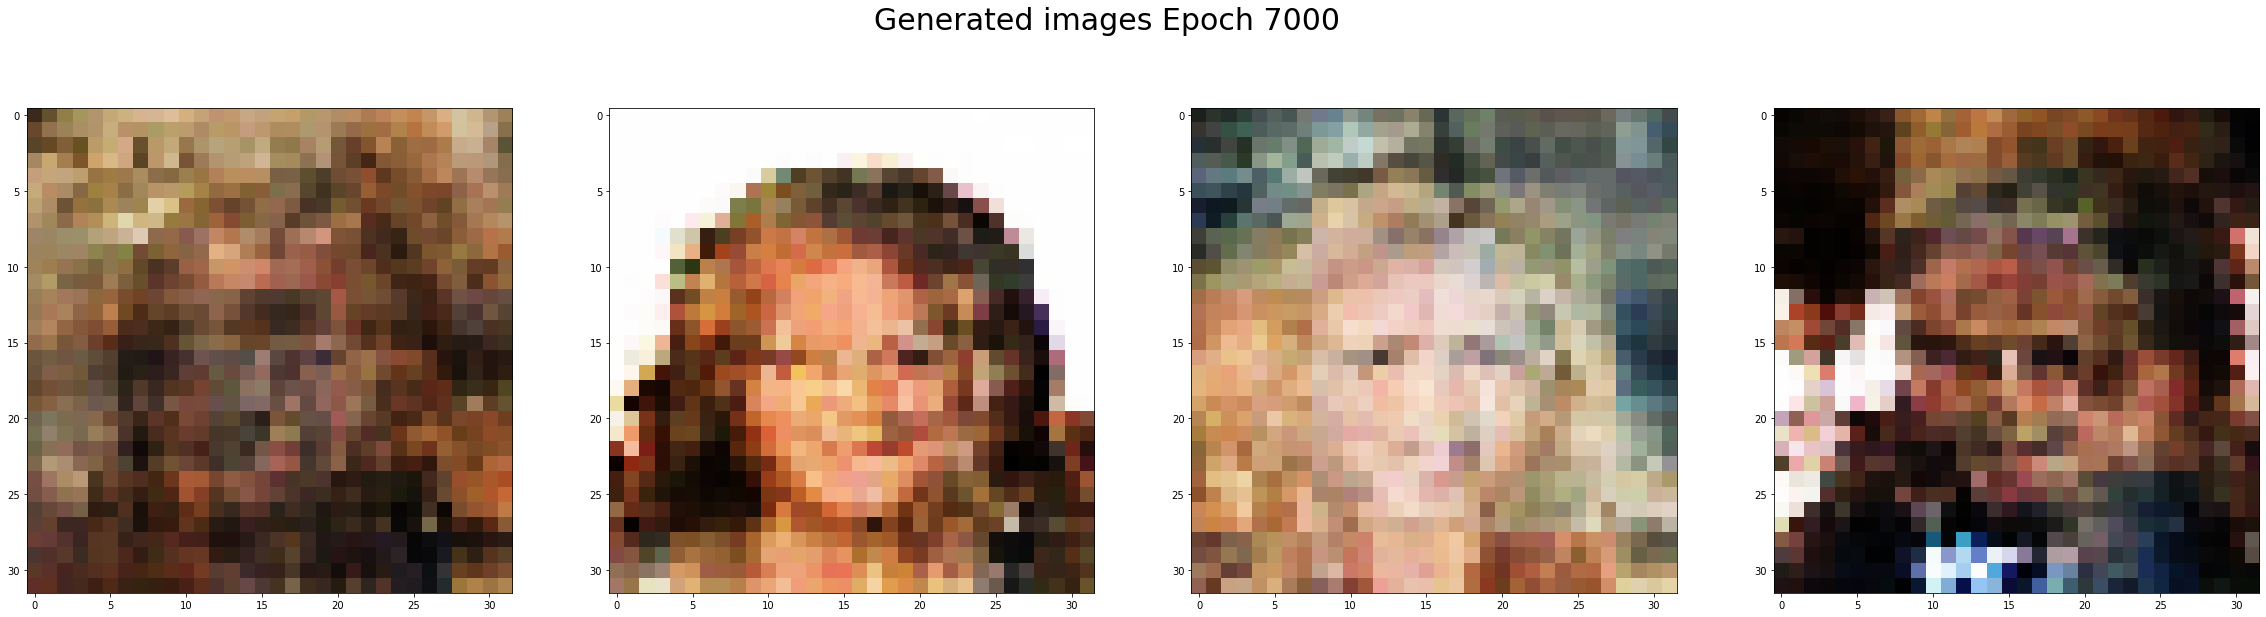

Epoch 07100 [D loss: 0.479, acc.: 077.1%] [G loss: 1.540]
Epoch 07200 [D loss: 0.459, acc.: 077.6%] [G loss: 1.518]
Epoch 07300 [D loss: 0.459, acc.: 078.2%] [G loss: 1.496]
Epoch 07400 [D loss: 0.449, acc.: 077.8%] [G loss: 1.556]
Epoch 07500 [D loss: 0.445, acc.: 079.7%] [G loss: 1.542]
Epoch 07600 [D loss: 0.453, acc.: 079.1%] [G loss: 1.506]
Epoch 07700 [D loss: 0.465, acc.: 076.8%] [G loss: 1.480]
Epoch 07800 [D loss: 0.435, acc.: 080.3%] [G loss: 1.631]
Epoch 07900 [D loss: 0.423, acc.: 080.5%] [G loss: 1.572]
Epoch 08000 [D loss: 0.436, acc.: 080.5%] [G loss: 1.511]


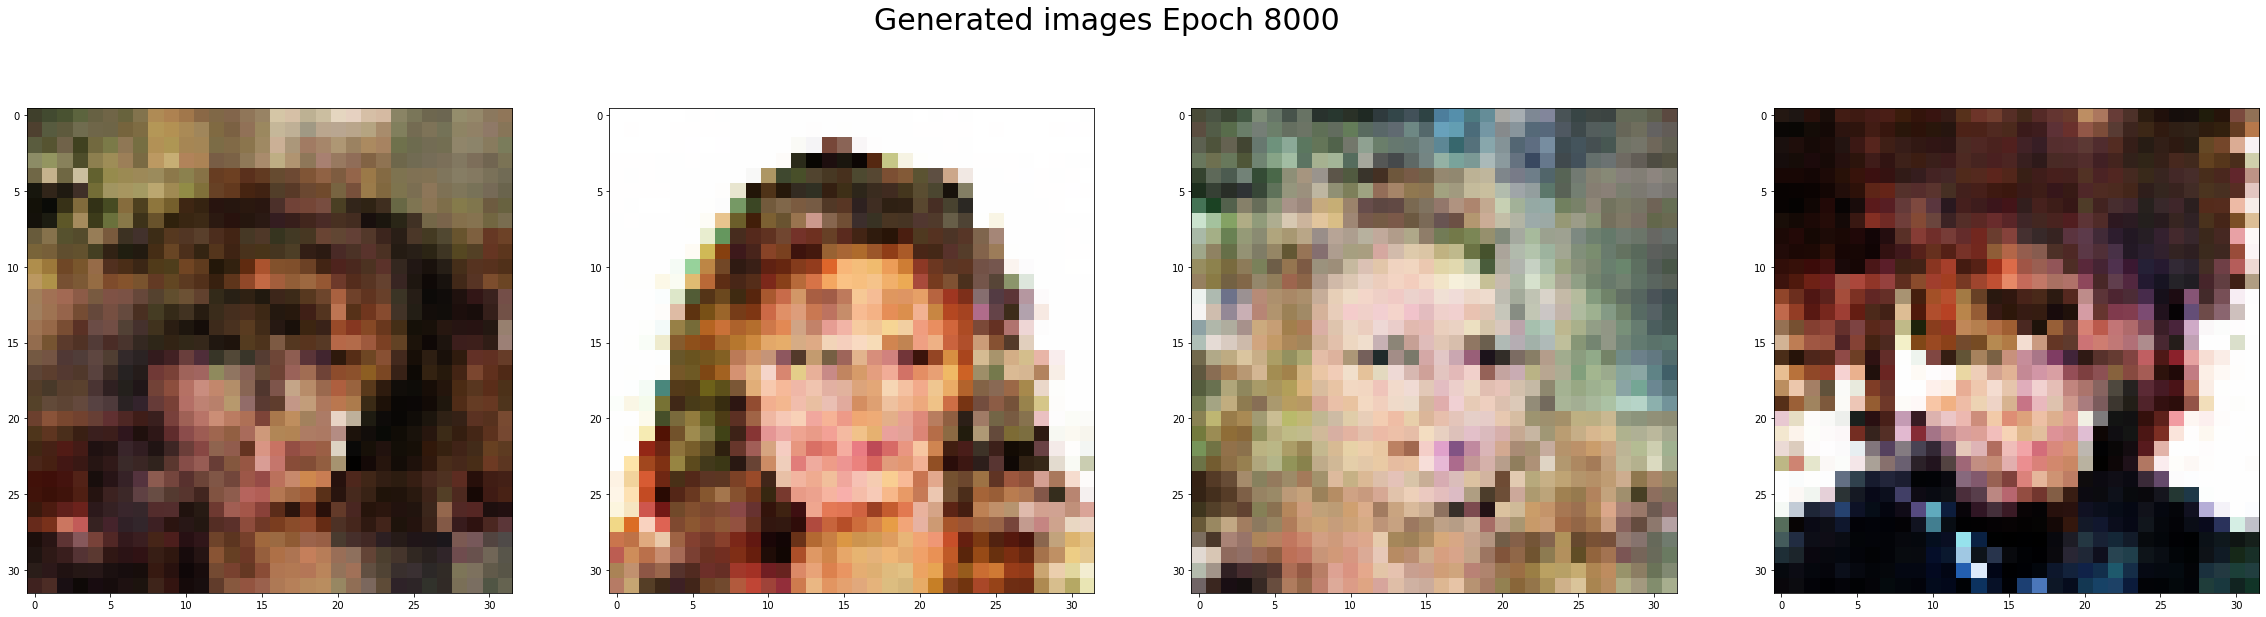

Epoch 08100 [D loss: 0.404, acc.: 081.8%] [G loss: 1.642]
Epoch 08200 [D loss: 0.466, acc.: 078.8%] [G loss: 1.546]
Epoch 08300 [D loss: 0.422, acc.: 081.2%] [G loss: 1.578]
Epoch 08400 [D loss: 0.421, acc.: 079.4%] [G loss: 1.625]
Epoch 08500 [D loss: 0.427, acc.: 079.5%] [G loss: 1.547]
Epoch 08600 [D loss: 0.405, acc.: 082.4%] [G loss: 1.558]
Epoch 08700 [D loss: 0.420, acc.: 080.1%] [G loss: 1.562]
Epoch 08800 [D loss: 0.415, acc.: 081.2%] [G loss: 1.587]
Epoch 08900 [D loss: 0.436, acc.: 079.9%] [G loss: 1.543]
Epoch 09000 [D loss: 0.676, acc.: 071.5%] [G loss: 1.684]


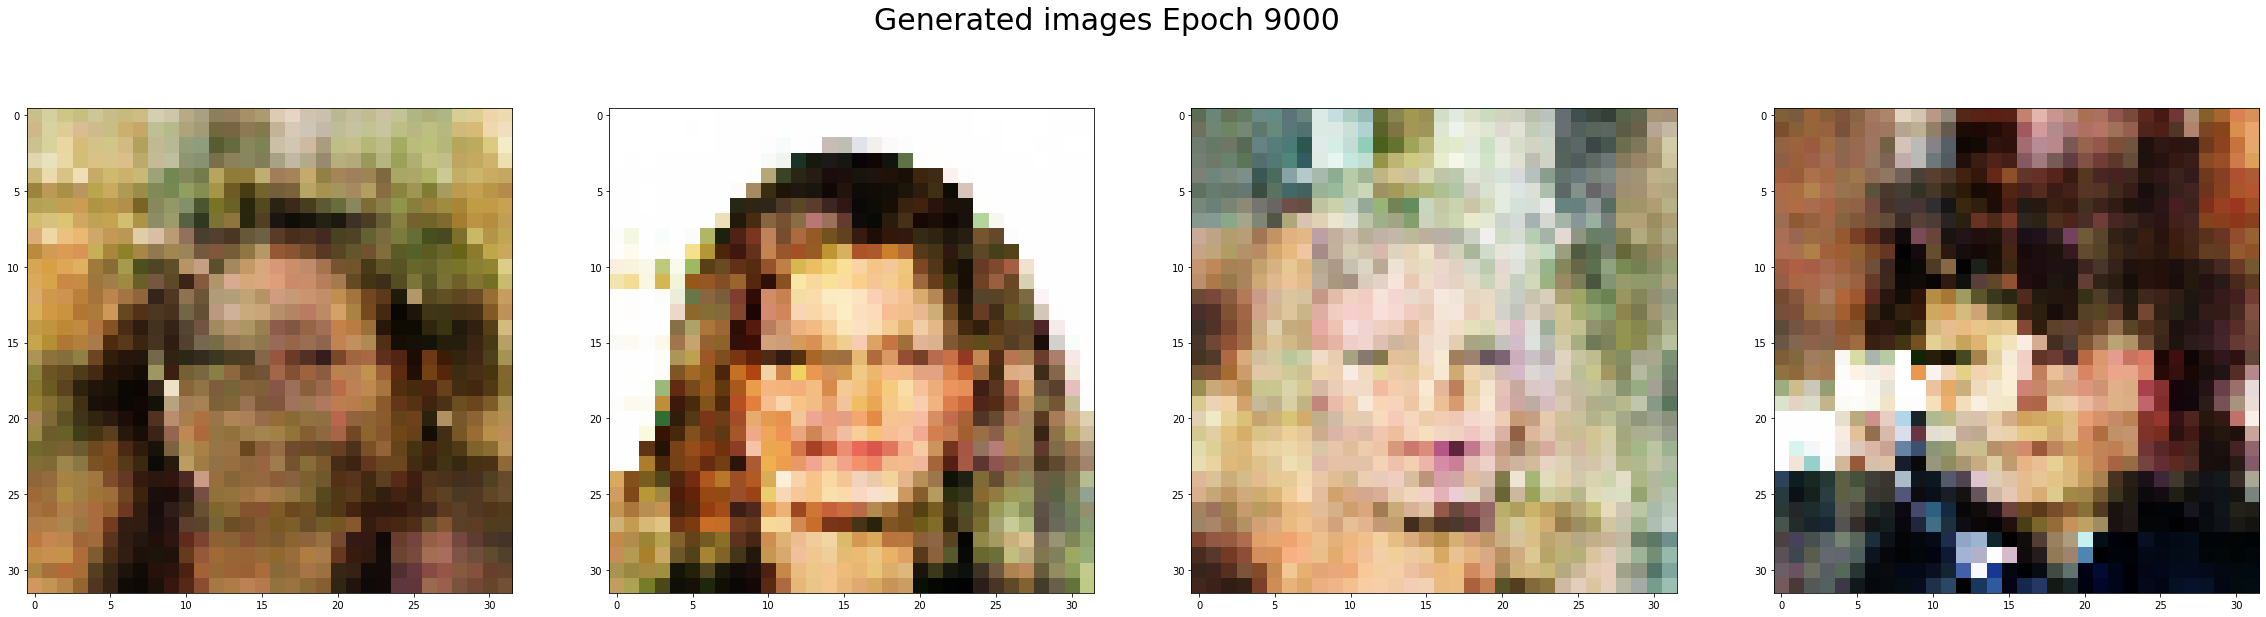

Epoch 09100 [D loss: 0.530, acc.: 075.6%] [G loss: 1.688]
Epoch 09200 [D loss: 0.393, acc.: 082.0%] [G loss: 1.595]
Epoch 09300 [D loss: 0.419, acc.: 079.8%] [G loss: 1.635]
Epoch 09400 [D loss: 0.431, acc.: 080.4%] [G loss: 1.612]
Epoch 09500 [D loss: 0.400, acc.: 081.8%] [G loss: 1.635]
Epoch 09600 [D loss: 0.417, acc.: 082.1%] [G loss: 1.600]
Epoch 09700 [D loss: 0.469, acc.: 078.4%] [G loss: 1.582]
Epoch 09800 [D loss: 0.430, acc.: 080.1%] [G loss: 1.589]
Epoch 09900 [D loss: 0.415, acc.: 081.2%] [G loss: 1.533]
Epoch 10000 [D loss: 0.384, acc.: 083.5%] [G loss: 1.675]


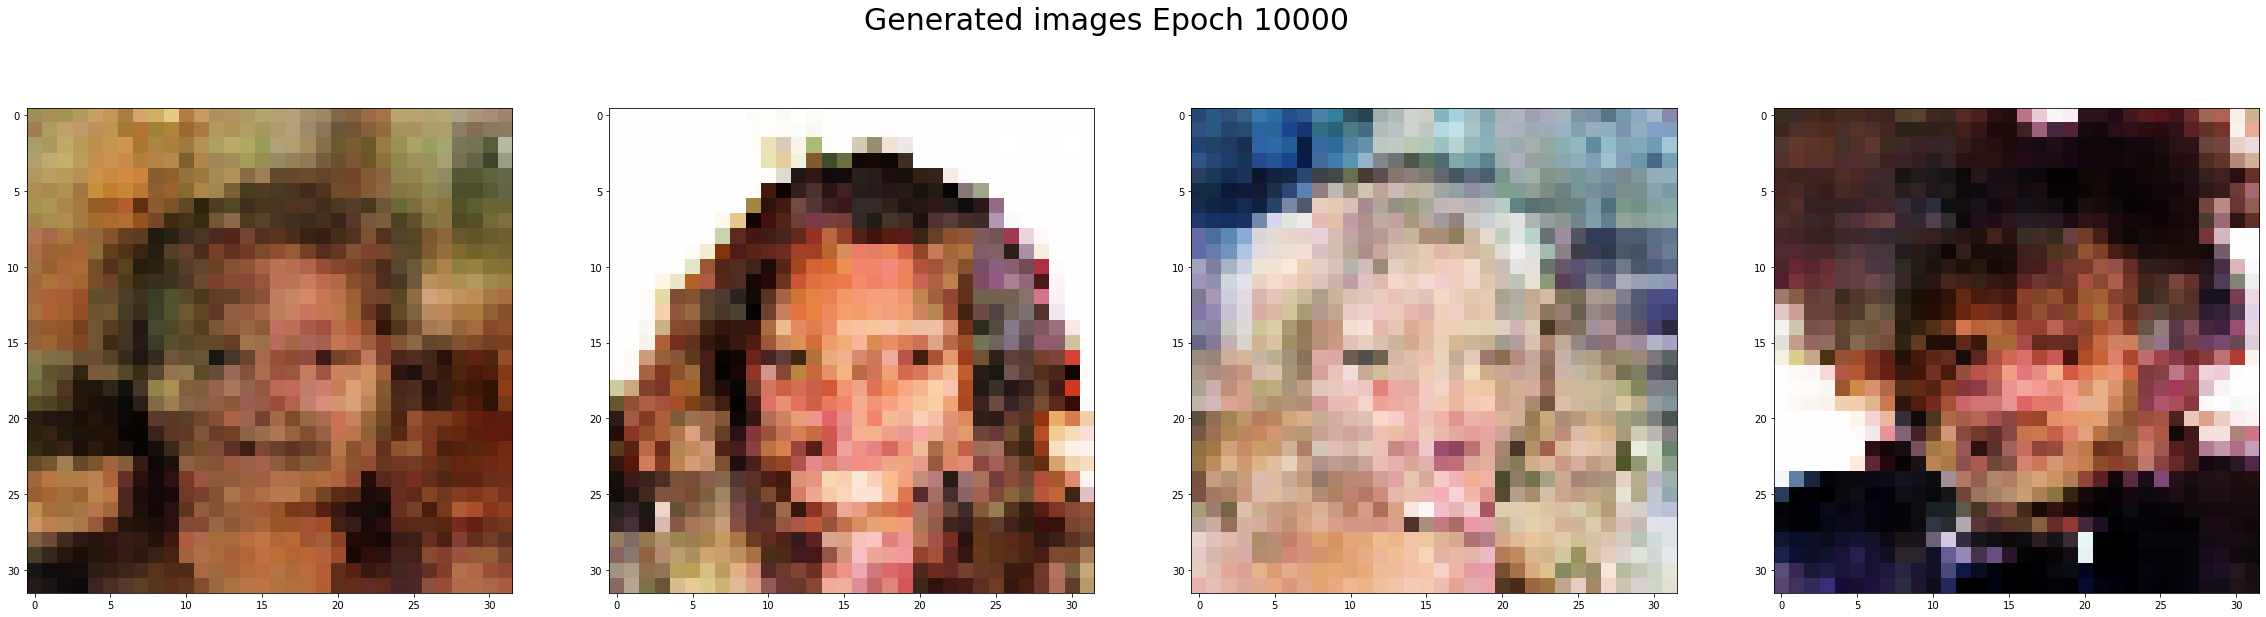

Epoch 10100 [D loss: 0.386, acc.: 083.0%] [G loss: 1.653]
Epoch 10200 [D loss: 0.411, acc.: 081.1%] [G loss: 1.671]
Epoch 10300 [D loss: 0.400, acc.: 081.8%] [G loss: 1.662]
Epoch 10400 [D loss: 0.411, acc.: 080.8%] [G loss: 1.695]
Epoch 10500 [D loss: 0.418, acc.: 081.3%] [G loss: 1.591]
Epoch 10600 [D loss: 0.389, acc.: 082.6%] [G loss: 1.698]
Epoch 10700 [D loss: 0.386, acc.: 083.1%] [G loss: 1.726]
Epoch 10800 [D loss: 0.415, acc.: 081.2%] [G loss: 1.652]
Epoch 10900 [D loss: 0.398, acc.: 080.9%] [G loss: 1.636]
Epoch 11000 [D loss: 0.399, acc.: 082.1%] [G loss: 1.776]


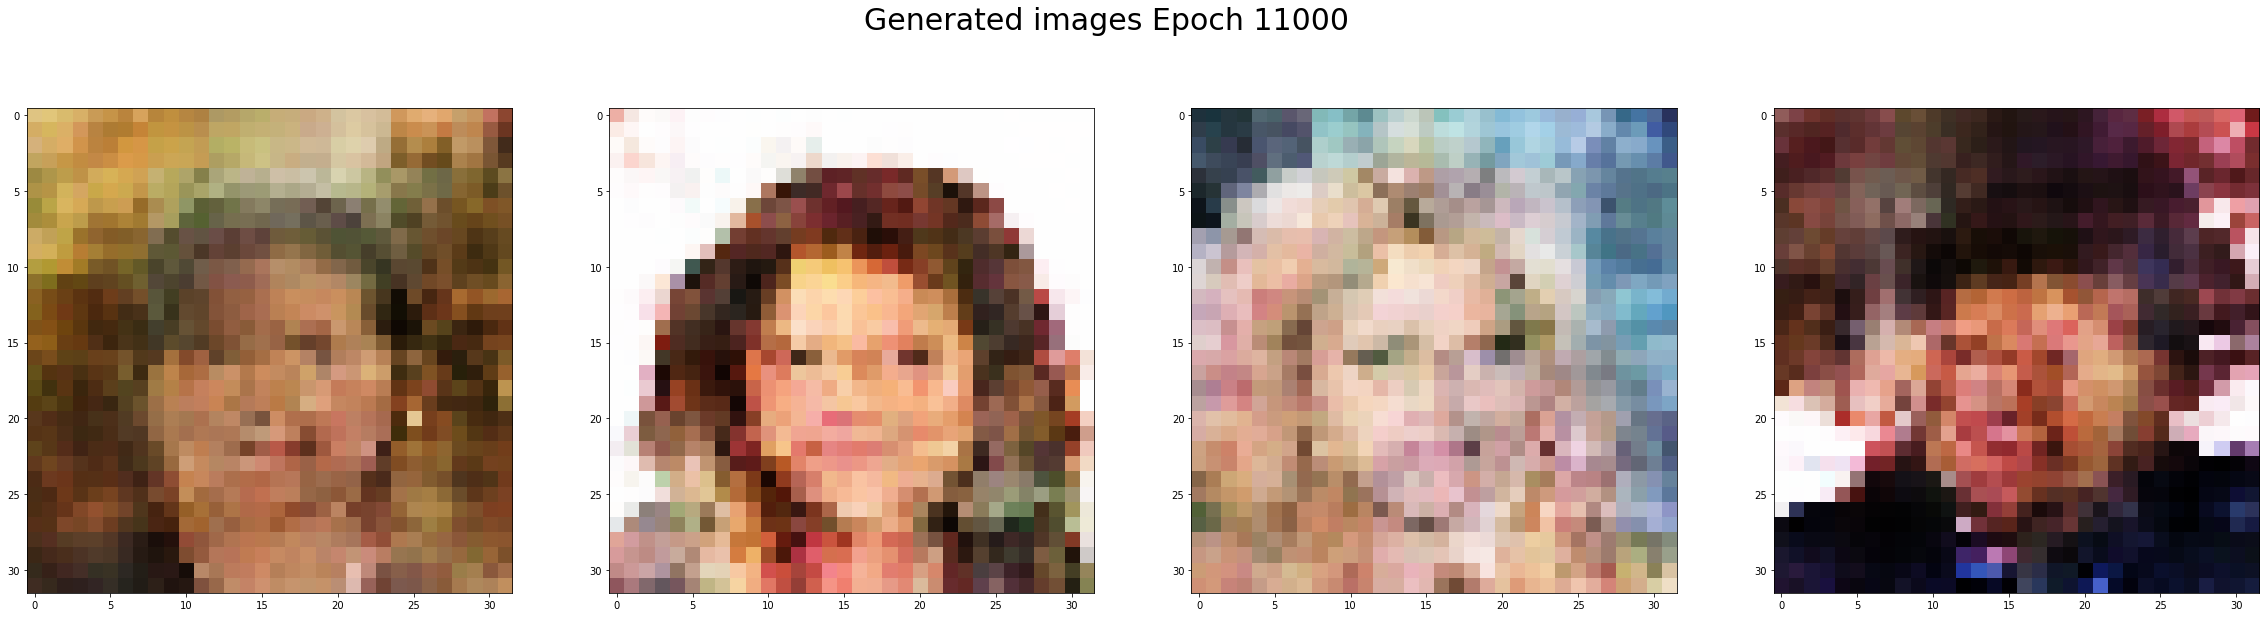

Epoch 11100 [D loss: 0.429, acc.: 079.7%] [G loss: 1.652]
Epoch 11200 [D loss: 0.405, acc.: 081.9%] [G loss: 1.695]
Epoch 11300 [D loss: 0.394, acc.: 082.7%] [G loss: 1.727]
Epoch 11400 [D loss: 0.352, acc.: 085.2%] [G loss: 1.735]
Epoch 11500 [D loss: 0.410, acc.: 081.2%] [G loss: 1.642]
Epoch 11600 [D loss: 0.394, acc.: 082.3%] [G loss: 1.721]
Epoch 11700 [D loss: 0.383, acc.: 082.5%] [G loss: 1.777]
Epoch 11800 [D loss: 0.381, acc.: 083.2%] [G loss: 1.752]
Epoch 11900 [D loss: 0.394, acc.: 082.5%] [G loss: 1.773]
Epoch 12000 [D loss: 0.419, acc.: 080.4%] [G loss: 1.697]


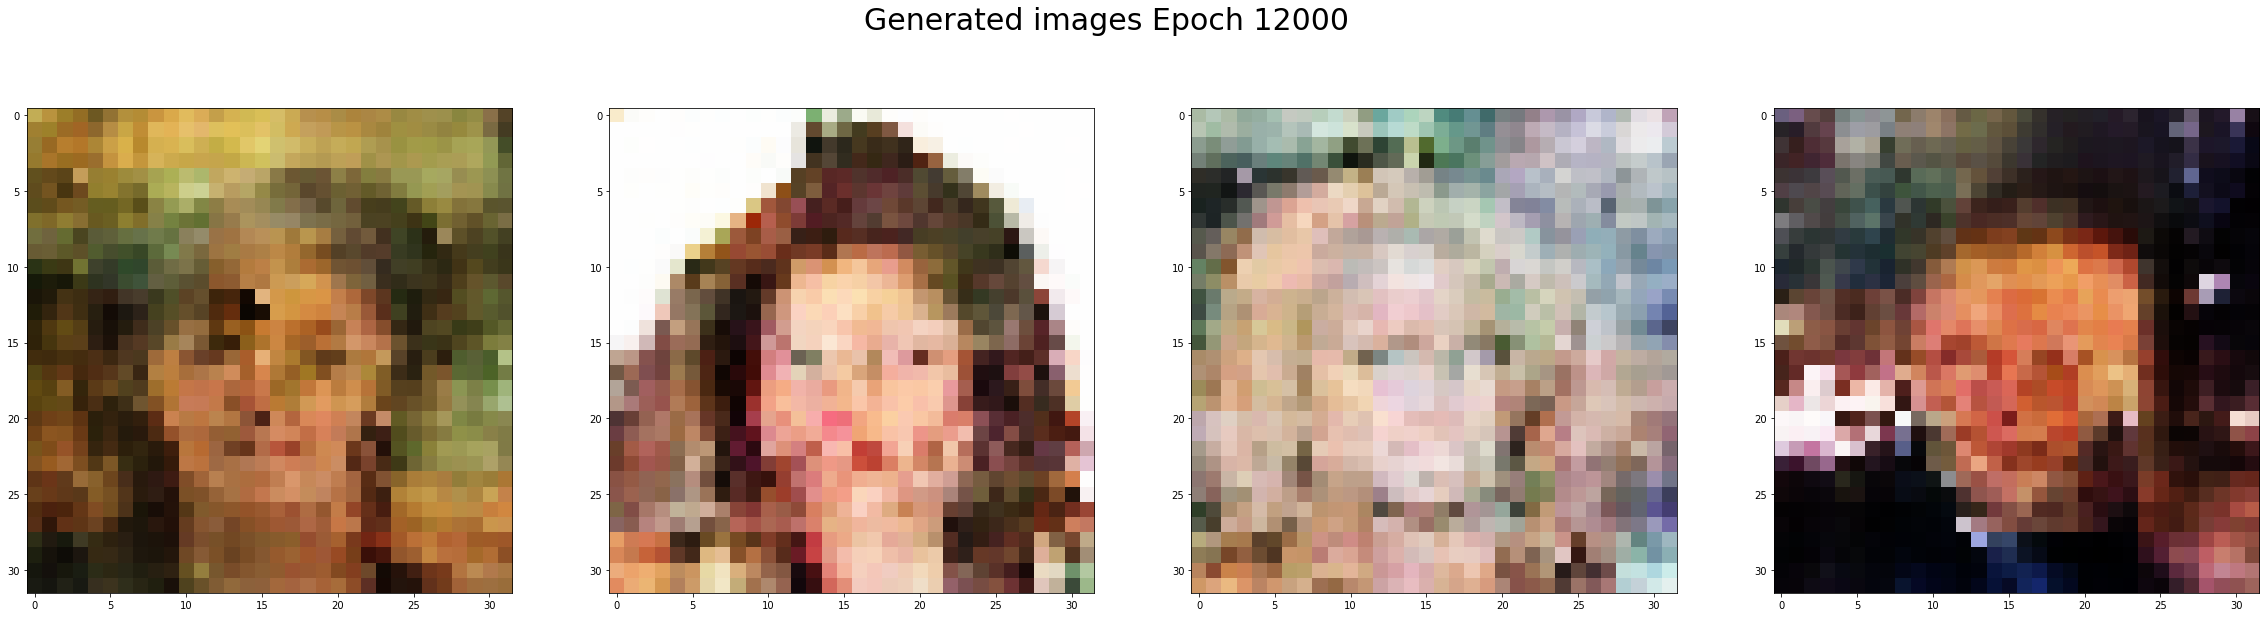

Epoch 12100 [D loss: 0.392, acc.: 082.7%] [G loss: 1.751]
Epoch 12200 [D loss: 0.389, acc.: 082.9%] [G loss: 1.731]
Epoch 12300 [D loss: 0.421, acc.: 080.3%] [G loss: 1.791]
Epoch 12400 [D loss: 0.375, acc.: 084.7%] [G loss: 1.910]
Epoch 12500 [D loss: 0.395, acc.: 082.2%] [G loss: 1.794]
Epoch 12600 [D loss: 0.373, acc.: 083.8%] [G loss: 1.790]
Epoch 12700 [D loss: 0.371, acc.: 082.6%] [G loss: 1.816]
Epoch 12800 [D loss: 0.403, acc.: 081.8%] [G loss: 1.739]
Epoch 12900 [D loss: 0.311, acc.: 086.7%] [G loss: 1.822]
Epoch 13000 [D loss: 0.349, acc.: 086.0%] [G loss: 1.880]


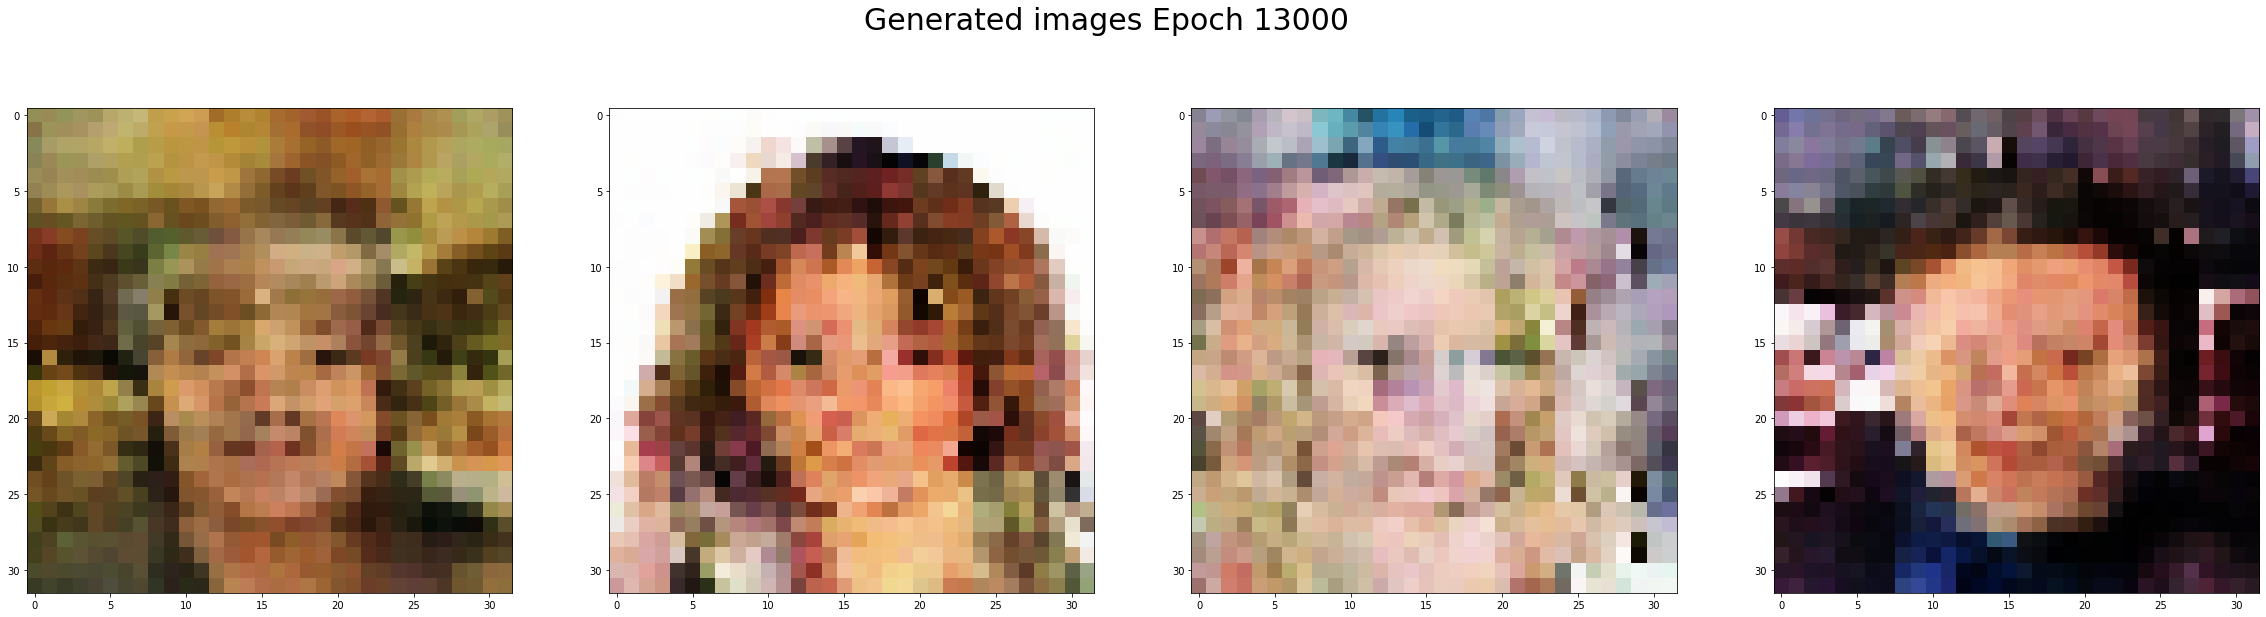

Epoch 13100 [D loss: 0.392, acc.: 082.7%] [G loss: 1.828]
Epoch 13200 [D loss: 0.381, acc.: 083.5%] [G loss: 1.932]
Epoch 13300 [D loss: 0.349, acc.: 085.0%] [G loss: 1.859]
Epoch 13400 [D loss: 0.348, acc.: 086.4%] [G loss: 1.933]
Epoch 13500 [D loss: 0.356, acc.: 083.5%] [G loss: 1.938]
Epoch 13600 [D loss: 0.396, acc.: 082.1%] [G loss: 1.882]
Epoch 13700 [D loss: 0.374, acc.: 083.3%] [G loss: 1.933]
Epoch 13800 [D loss: 0.362, acc.: 084.3%] [G loss: 1.992]
Epoch 13900 [D loss: 0.365, acc.: 083.1%] [G loss: 1.934]
Epoch 14000 [D loss: 0.349, acc.: 085.1%] [G loss: 1.921]


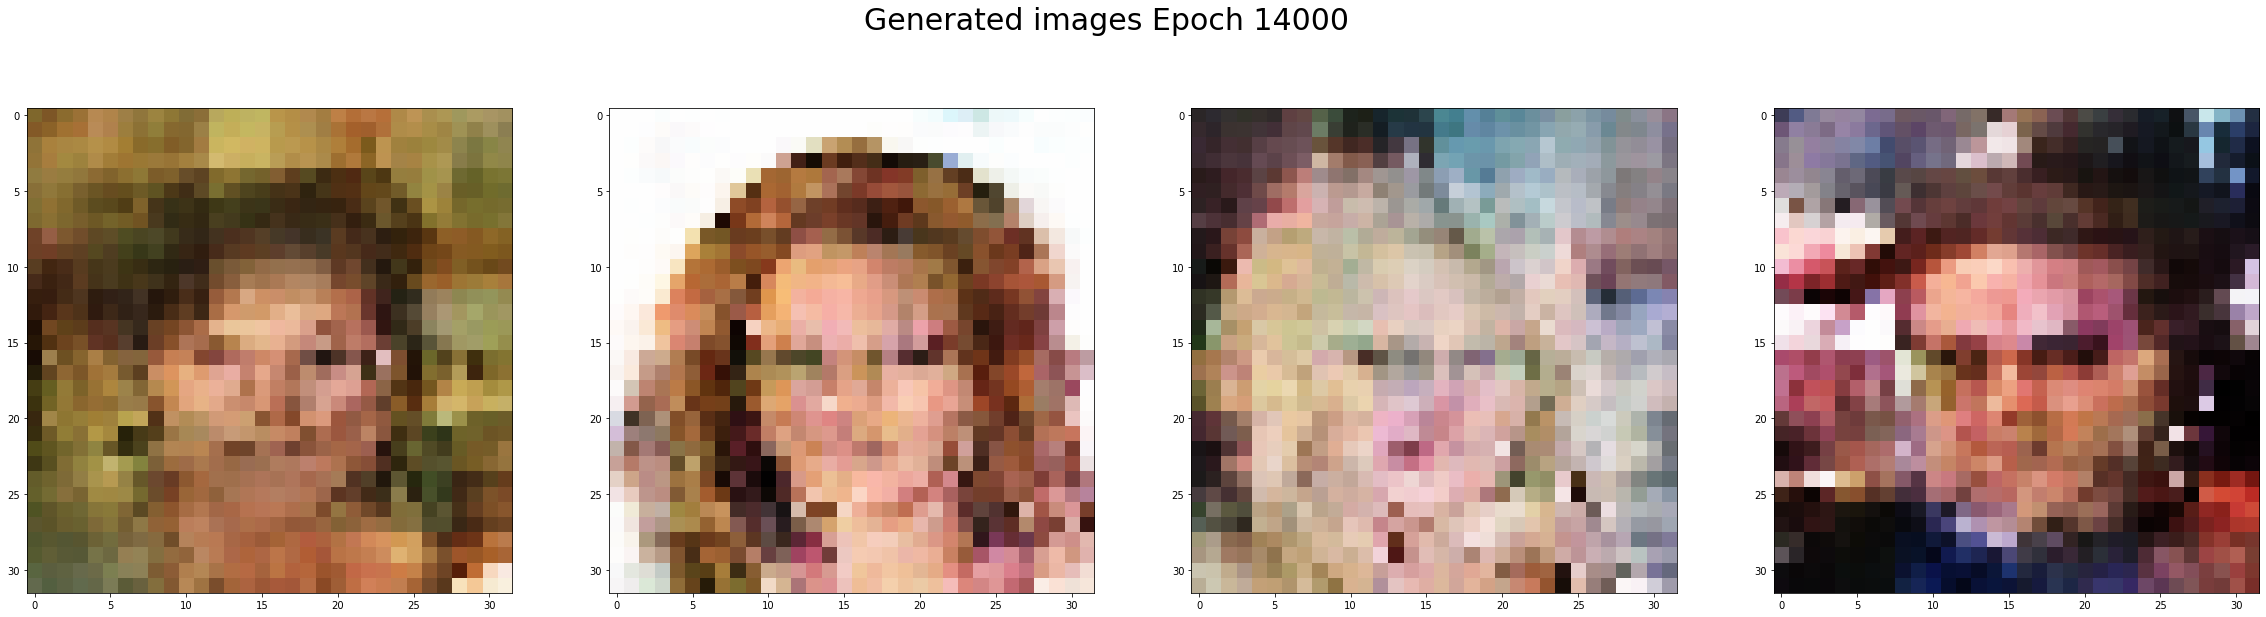

Epoch 14100 [D loss: 0.331, acc.: 086.3%] [G loss: 2.074]
Epoch 14200 [D loss: 0.330, acc.: 086.2%] [G loss: 2.011]
Epoch 14300 [D loss: 0.361, acc.: 083.0%] [G loss: 1.992]
Epoch 14400 [D loss: 0.321, acc.: 086.7%] [G loss: 2.064]
Epoch 14500 [D loss: 0.344, acc.: 085.4%] [G loss: 1.999]
Epoch 14600 [D loss: 0.318, acc.: 086.2%] [G loss: 2.129]
Epoch 14700 [D loss: 0.369, acc.: 082.3%] [G loss: 1.999]
Epoch 14800 [D loss: 0.308, acc.: 086.8%] [G loss: 2.045]
Epoch 14900 [D loss: 0.370, acc.: 083.2%] [G loss: 2.044]
Epoch 15000 [D loss: 0.325, acc.: 086.0%] [G loss: 1.965]


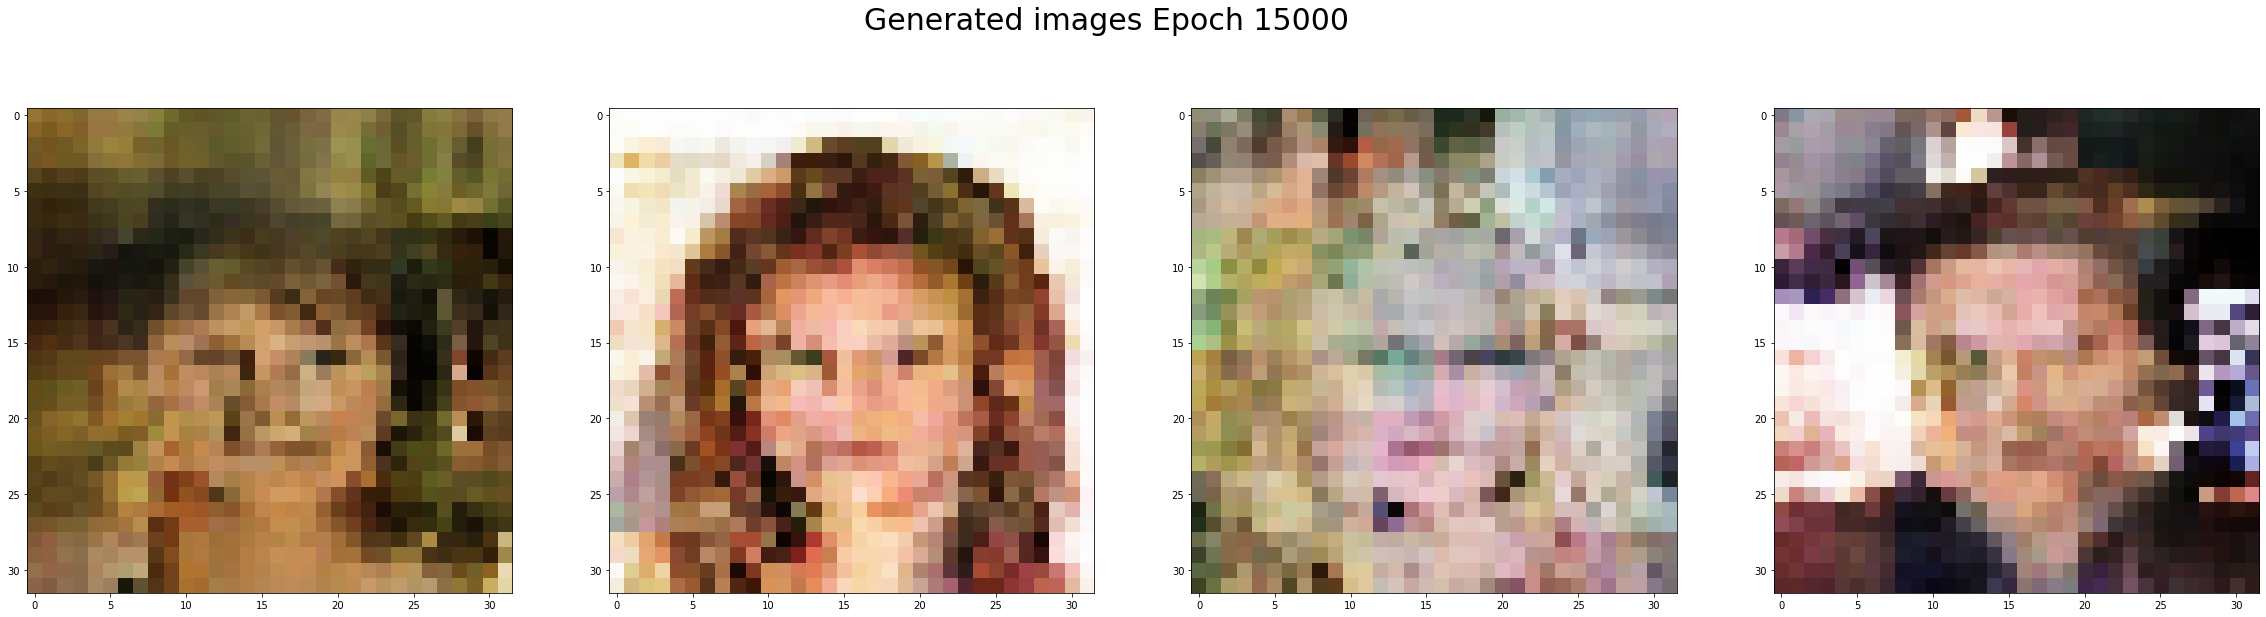

Epoch 15100 [D loss: 0.351, acc.: 084.1%] [G loss: 2.154]
Epoch 15200 [D loss: 0.325, acc.: 085.7%] [G loss: 2.098]
Epoch 15300 [D loss: 0.329, acc.: 085.8%] [G loss: 2.004]
Epoch 15400 [D loss: 0.316, acc.: 086.7%] [G loss: 2.149]
Epoch 15500 [D loss: 0.317, acc.: 086.4%] [G loss: 2.163]
Epoch 15600 [D loss: 0.306, acc.: 087.6%] [G loss: 2.122]
Epoch 15700 [D loss: 0.307, acc.: 086.8%] [G loss: 2.273]
Epoch 15800 [D loss: 0.299, acc.: 087.4%] [G loss: 2.107]
Epoch 15900 [D loss: 0.343, acc.: 085.4%] [G loss: 2.195]
Epoch 16000 [D loss: 0.281, acc.: 089.8%] [G loss: 2.180]


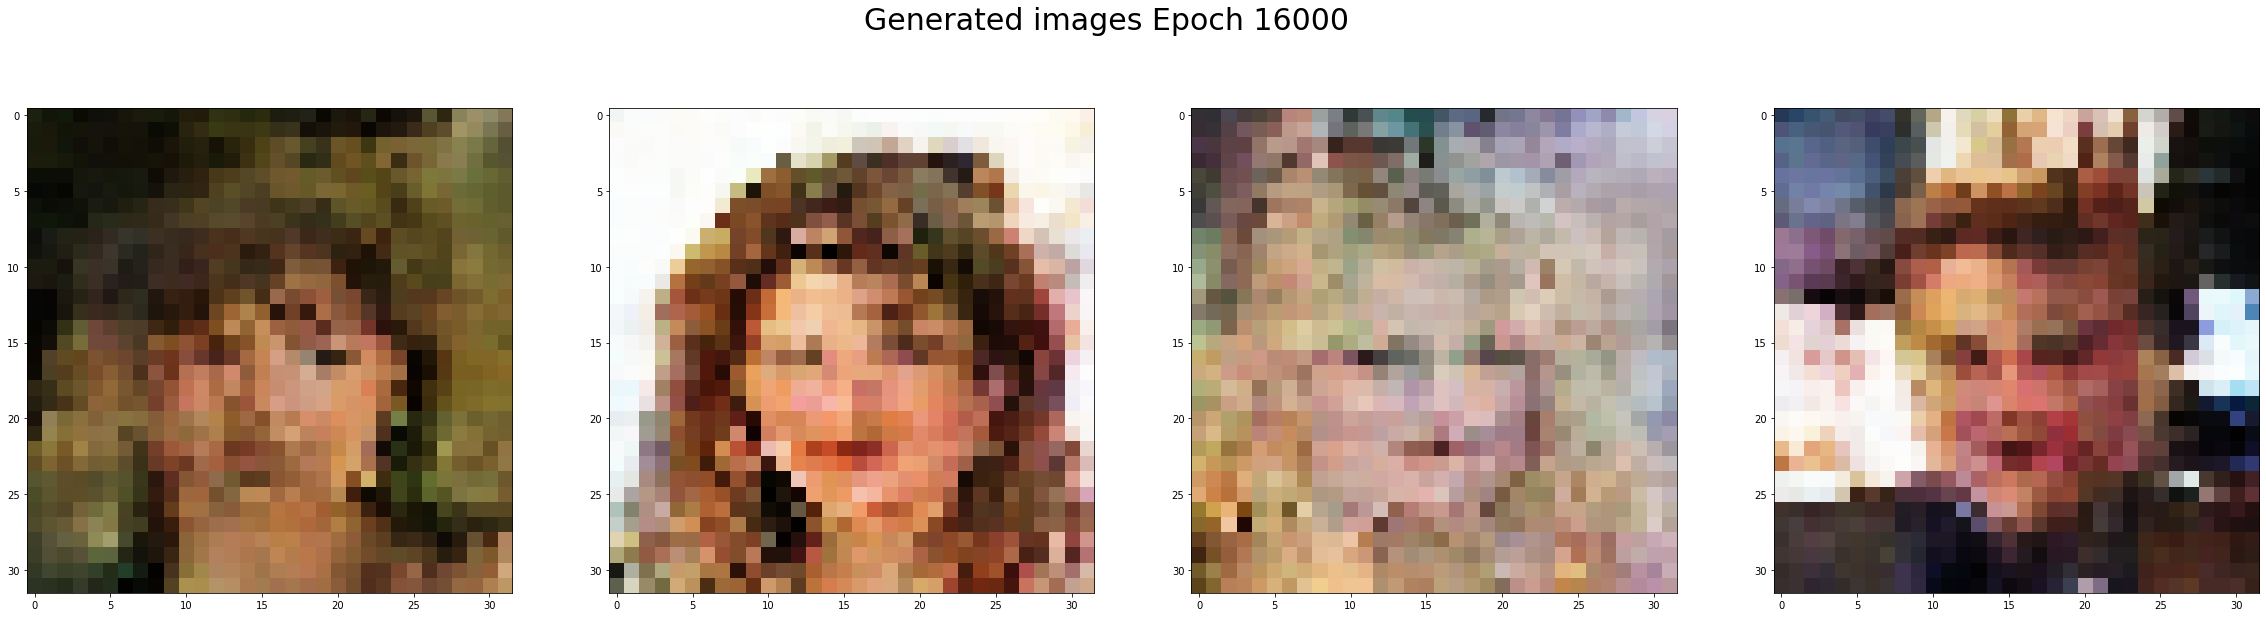

Epoch 16100 [D loss: 0.300, acc.: 087.8%] [G loss: 2.313]
Epoch 16200 [D loss: 0.290, acc.: 088.3%] [G loss: 2.238]
Epoch 16300 [D loss: 0.295, acc.: 088.0%] [G loss: 2.166]
Epoch 16400 [D loss: 0.319, acc.: 085.9%] [G loss: 2.300]
Epoch 16500 [D loss: 0.318, acc.: 086.4%] [G loss: 2.188]
Epoch 16600 [D loss: 0.309, acc.: 087.4%] [G loss: 2.341]
Epoch 16700 [D loss: 0.295, acc.: 087.4%] [G loss: 2.375]
Epoch 16800 [D loss: 0.275, acc.: 088.5%] [G loss: 2.245]
Epoch 16900 [D loss: 0.308, acc.: 087.2%] [G loss: 2.251]
Epoch 17000 [D loss: 0.310, acc.: 087.3%] [G loss: 2.488]


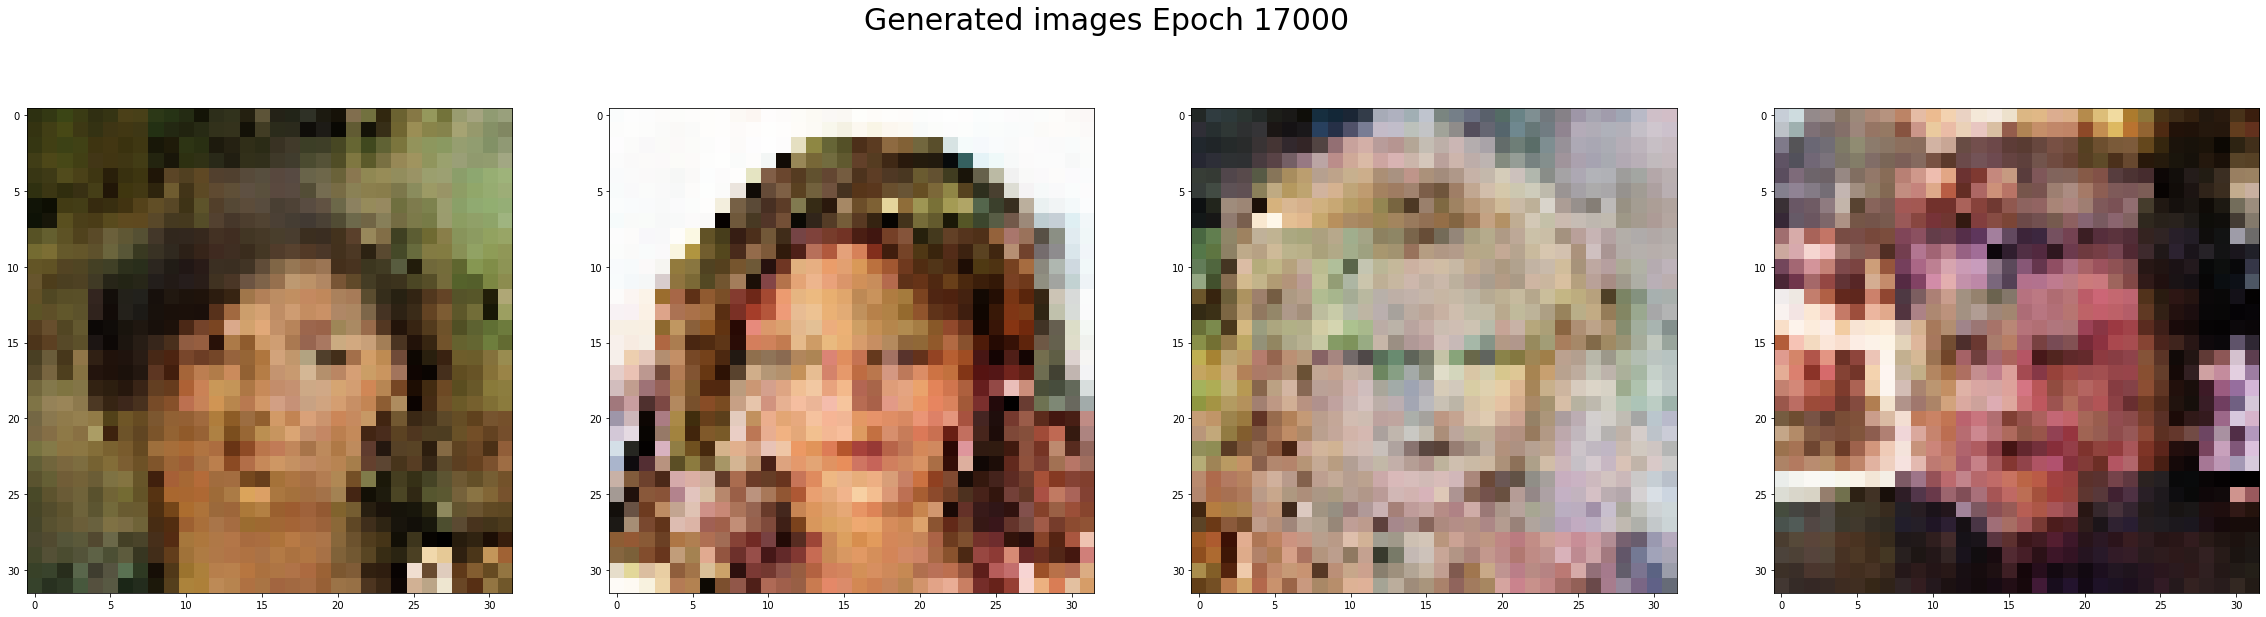

Epoch 17100 [D loss: 0.295, acc.: 088.0%] [G loss: 2.451]
Epoch 17200 [D loss: 0.287, acc.: 087.8%] [G loss: 2.424]
Epoch 17300 [D loss: 0.304, acc.: 087.5%] [G loss: 2.284]
Epoch 17400 [D loss: 0.318, acc.: 086.8%] [G loss: 2.358]
Epoch 17500 [D loss: 0.290, acc.: 087.2%] [G loss: 2.470]
Epoch 17600 [D loss: 0.281, acc.: 088.5%] [G loss: 2.457]
Epoch 17700 [D loss: 0.281, acc.: 087.4%] [G loss: 2.389]
Epoch 17800 [D loss: 0.266, acc.: 089.0%] [G loss: 2.536]
Epoch 17900 [D loss: 0.225, acc.: 091.3%] [G loss: 2.756]
Epoch 18000 [D loss: 0.206, acc.: 093.1%] [G loss: 2.618]


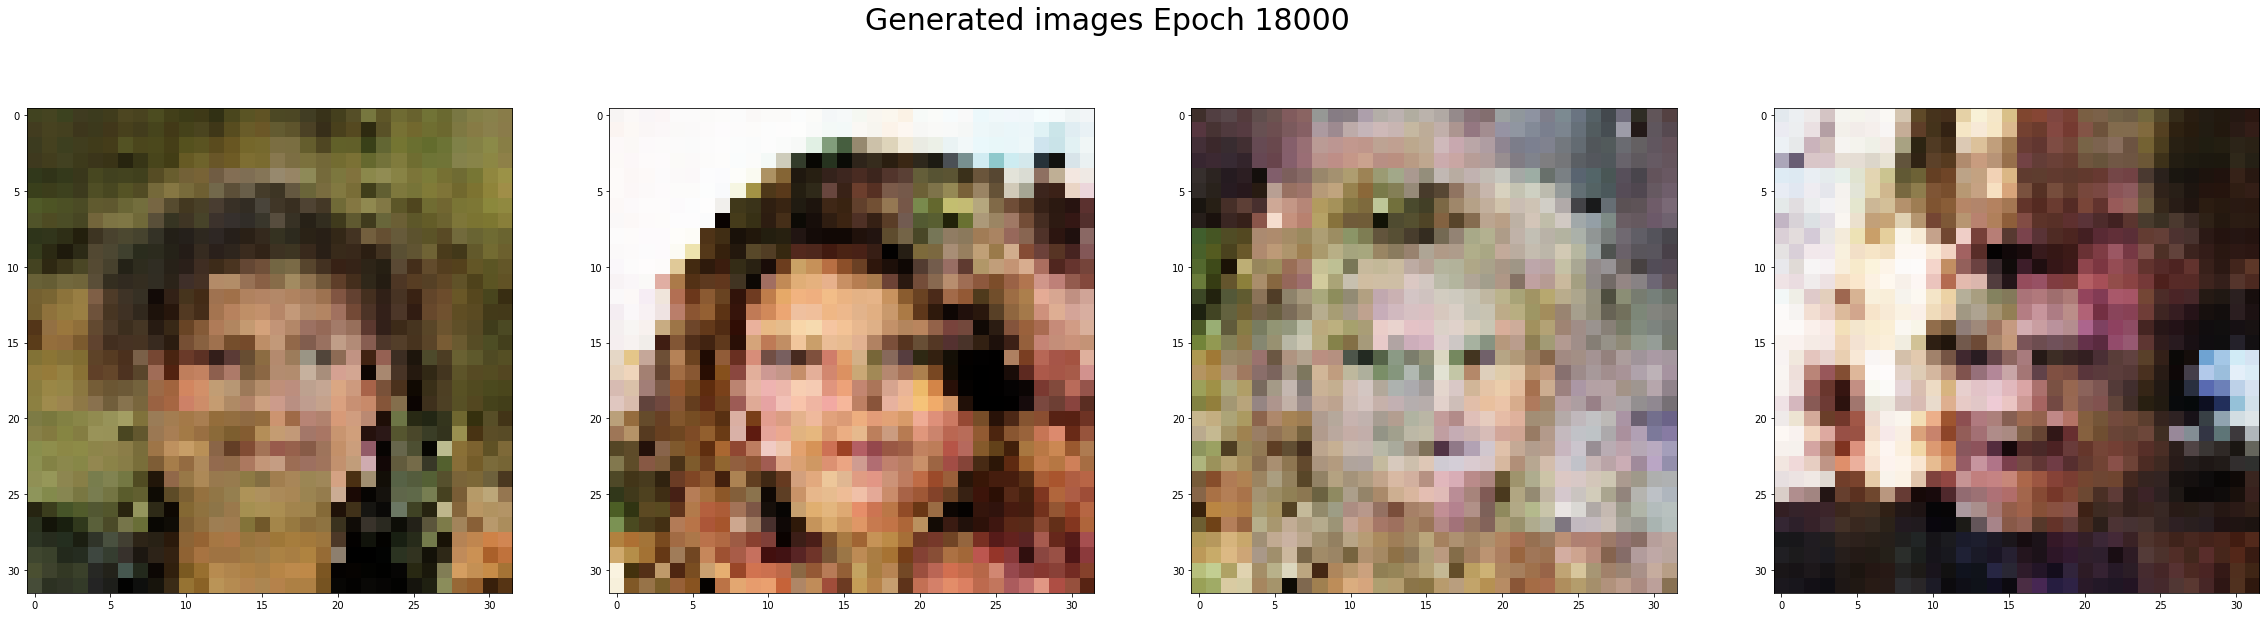

Epoch 18100 [D loss: 0.251, acc.: 089.9%] [G loss: 2.666]
Epoch 18200 [D loss: 0.262, acc.: 089.4%] [G loss: 2.537]
Epoch 18300 [D loss: 0.275, acc.: 089.6%] [G loss: 2.648]
Epoch 18400 [D loss: 0.247, acc.: 090.8%] [G loss: 2.686]
Epoch 18500 [D loss: 0.212, acc.: 091.4%] [G loss: 2.895]
Epoch 18600 [D loss: 0.249, acc.: 089.7%] [G loss: 2.687]
Epoch 18700 [D loss: 0.219, acc.: 092.5%] [G loss: 2.764]
Epoch 18800 [D loss: 0.233, acc.: 090.6%] [G loss: 2.680]
Epoch 18900 [D loss: 0.255, acc.: 089.4%] [G loss: 3.032]
Epoch 19000 [D loss: 0.201, acc.: 092.3%] [G loss: 2.881]


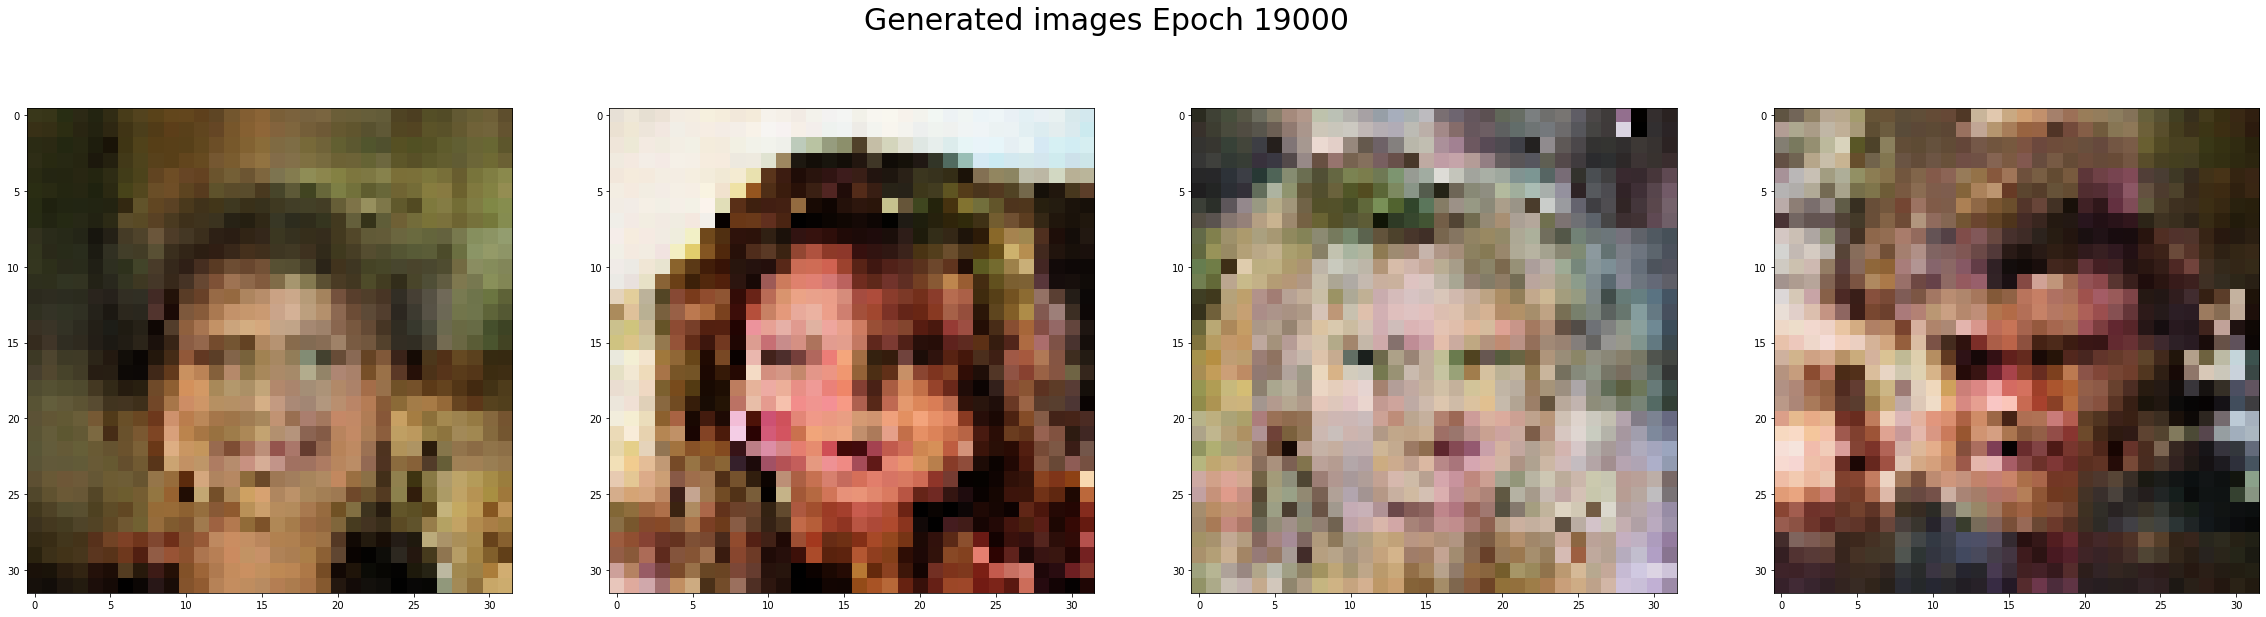

Epoch 19100 [D loss: 0.205, acc.: 092.2%] [G loss: 3.072]
Epoch 19200 [D loss: 0.186, acc.: 093.2%] [G loss: 2.949]
Epoch 19300 [D loss: 0.213, acc.: 091.2%] [G loss: 3.082]
Epoch 19400 [D loss: 0.209, acc.: 092.4%] [G loss: 3.072]
Epoch 19500 [D loss: 0.196, acc.: 092.2%] [G loss: 3.052]
Epoch 19600 [D loss: 0.187, acc.: 092.3%] [G loss: 3.141]
Epoch 19700 [D loss: 0.227, acc.: 091.6%] [G loss: 3.117]
Epoch 19800 [D loss: 0.168, acc.: 093.8%] [G loss: 3.145]
Epoch 19900 [D loss: 0.152, acc.: 095.5%] [G loss: 3.291]
----------
Time took: 89.83 min


In [27]:
dir_result="./result_GAN/"

try:
    os.mkdir(dir_result)
except:
    pass
    
start_time = time.time()

_models = combined, discriminator, generator          

history = train(_models, X_train, noise, dir_result=dir_result, epochs=20000, 
                batch_size=128 * 8)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time) / 60))

### Displaying results

##10 points

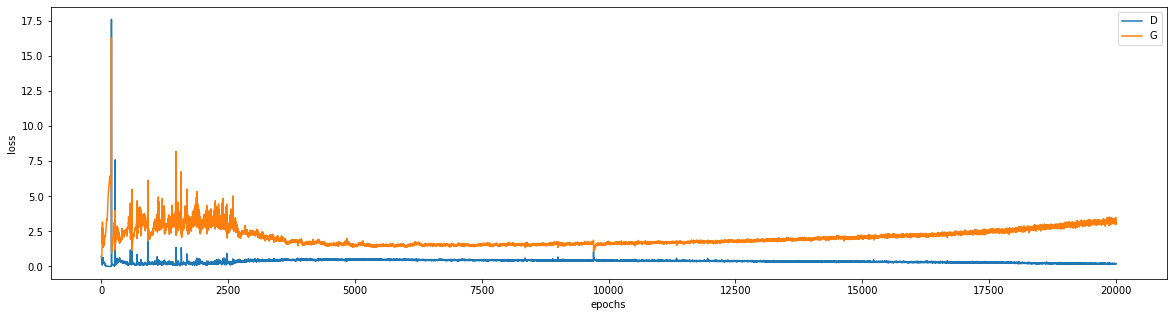

In [28]:
import pandas as pd 
hist = pd.DataFrame(history)
plt.figure(figsize=(20,5))
for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [29]:
def makegif(dir_images):
    import imageio
    filenames = np.sort(os.listdir(dir_images))
    filenames = [fnm for fnm in filenames if ".png" in fnm]

    with imageio.get_writer(dir_images + '/image.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(dir_images + filename)
            writer.append_data(image)            
makegif(dir_result)

![SegmentLocal](/content/result_GAN/image.gif "segment")

Checking out autoencoders

In [36]:
img_in = layers.Input(shape=img_shape)

# discriminator with the final output layer = 100 network as encoder
discriminator_encoder = build_discriminator(img_shape, 100)

# discriminator as encoder
encoder = discriminator_encoder(img_in)

# generator as decoder
generator.trainable = False
img_out = generator(encoder) 

encoder_decoder = models.Model(img_in, img_out)
encoder_decoder.compile(loss='mse', optimizer=optimizer)

encoder_decoder.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_13 (Functional)   (None, 100)               6813060   
_________________________________________________________________
functional_7 (Functional)    (None, 32, 32, 3)         8584515   
Total params: 15,397,575
Trainable params: 6,813,060
Non-trainable params: 8,584,515
_________________________________________________________________


In [37]:
start_time = time.time()
history_ed = encoder_decoder.fit(X_train, X_train, validation_data=(X_test, X_test),
                                 epochs=10,verbose=2)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time) / 60))

Epoch 1/10
625/625 - 5s - loss: 0.0475 - val_loss: 0.0419
Epoch 2/10
625/625 - 4s - loss: 0.0413 - val_loss: 0.0406
Epoch 3/10
625/625 - 4s - loss: 0.0400 - val_loss: 0.0396
Epoch 4/10
625/625 - 4s - loss: 0.0393 - val_loss: 0.0394
Epoch 5/10
625/625 - 4s - loss: 0.0388 - val_loss: 0.0390
Epoch 6/10
625/625 - 4s - loss: 0.0385 - val_loss: 0.0387
Epoch 7/10
625/625 - 4s - loss: 0.0383 - val_loss: 0.0385
Epoch 8/10
625/625 - 4s - loss: 0.0381 - val_loss: 0.0383
Epoch 9/10
625/625 - 4s - loss: 0.0379 - val_loss: 0.0382
Epoch 10/10
625/625 - 4s - loss: 0.0377 - val_loss: 0.0381
----------
Time took: 0.74 min


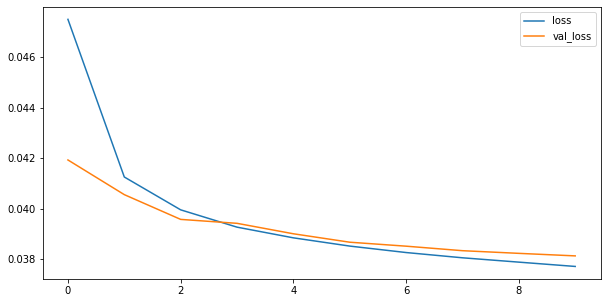

In [38]:
plt.figure(figsize=(10,5))
for col in history_ed.history.keys():
    plt.plot(history_ed.history[col],label=col)
plt.legend()
plt.show()
X_pred = encoder_decoder.predict(X_test)

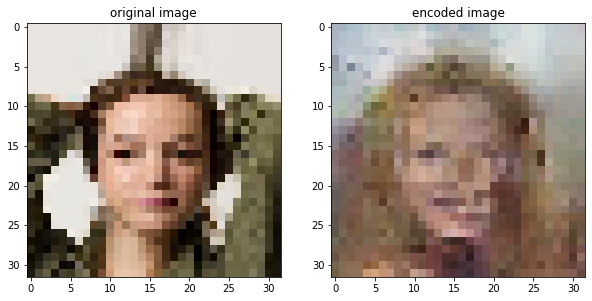

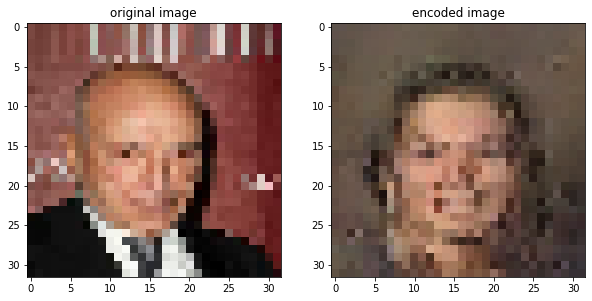

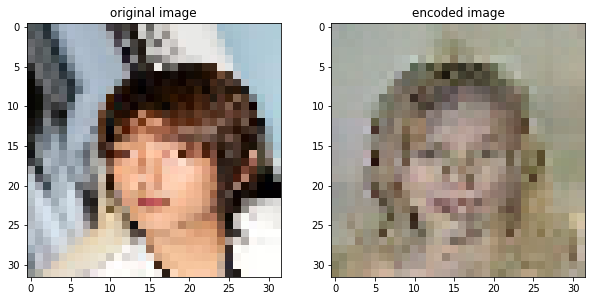

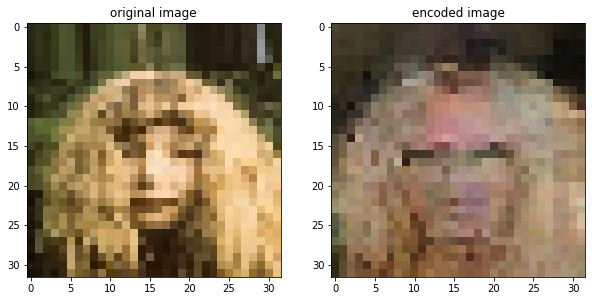

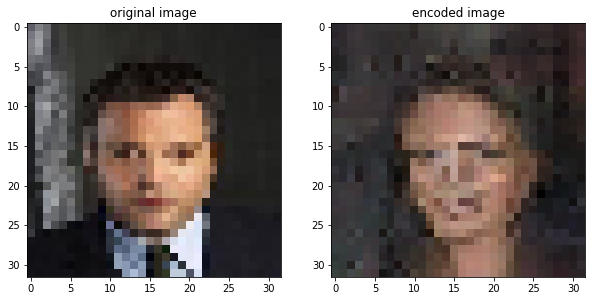

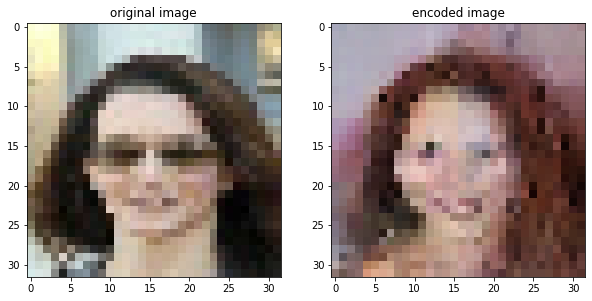

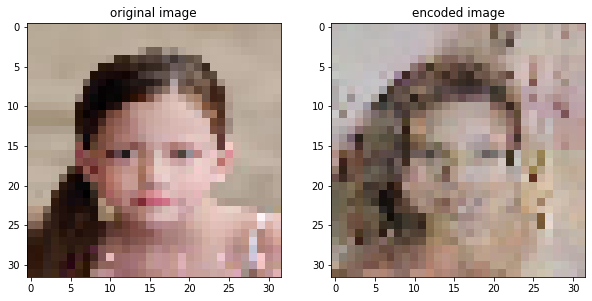

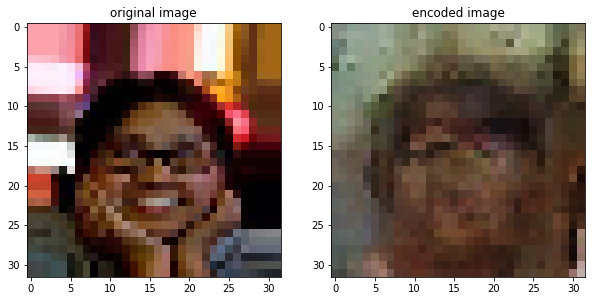

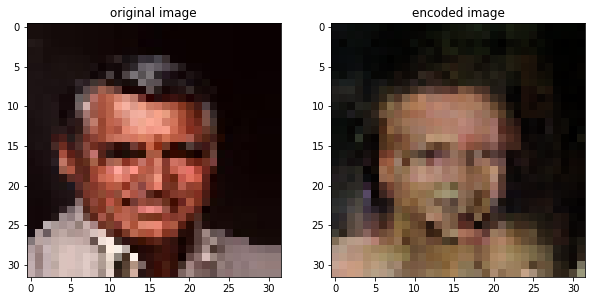

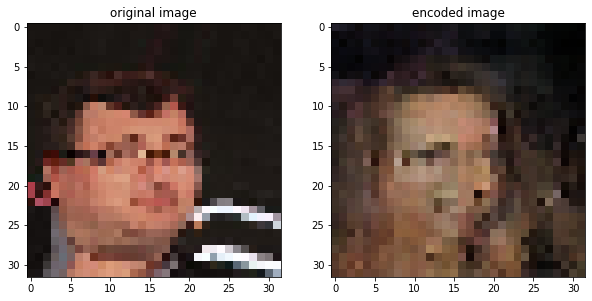

In [39]:
Ntest = 10

for irow in range(Ntest):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(X_test[irow])
    ax.set_title("original image")
    
    ax = fig.add_subplot(1,2,2)
    ax.imshow(X_pred[irow])
    ax.set_title("encoded image")
    
    plt.show()